# WDWY MTA Turnstile Analysis 

WomenTechWomenYes (WTWY) is looking to efficiently place their street teams at NYC subway stations in order to build awareness through email collection prior to their upcoming gala. Using background research from the book *Invisible Women* by Caroline Criado Perez, our team focused on identifying stations with high ridership in close proximity to schools and daycares - areas that are commonly visited in women's urban travel patterns. Our team used MTA turnstile data and location data from stations, schools, and daycares to optimize the WTWY street team schedule. 

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import inspect
import warnings
warnings.filterwarnings("ignore")

engine = create_engine("sqlite:///mta_data.db")
insp = inspect(engine)

## Initial SQL Exploration

To help us better understand the data in our MTA database, we'll start with some exploratory queries. Our work in SQL will allow us to decide how we want to structure and filter our data. 

To start, it looks like our dataset covers 379 NYC subway station names. 

In [2]:
pd.read_sql('SELECT COUNT(DISTINCT STATION)FROM mta_data;', engine)

COUNT(DISTINCT STATION)
0                      379

Below we can see that in a single station, you can have multiple C/A's, Line names, Units, and SCPs. We can think of an SCP as a distinct turnstile, with Unit and C/A representing larger divisions of the station. This means that a distinct combination of Station, Line name, C/A, Unit, and SCP will lead us to a single turnstile. 

In [3]:
pd.read_sql('SELECT STATION, COUNT(DISTINCT "C/A"), COUNT(DISTINCT LINENAME), COUNT(DISTINCT UNIT), COUNT(DISTINCT SCP) FROM mta_data GROUP BY STATION ORDER BY COUNT(DISTINCT SCP) DESC LIMIT 3;', engine)

STATION  COUNT(DISTINCT "C/A")  COUNT(DISTINCT LINENAME)  \
0        FULTON ST                     12                         3   
1   34 ST-PENN STA                     13                         3   
2  GRD CNTRL-42 ST                      8                         1   

   COUNT(DISTINCT UNIT)  COUNT(DISTINCT SCP)  
0                     3                   80  
1                     4                   63  
2                     4                   54

Knowing that a station can have multiple line names (and multiple locations associated with those lines), we'll want to break out the stations by line name in our dataframe. Here's an example of a station that we'll need to separate out: 

In [4]:
pd.read_sql('SELECT DISTINCT(LINENAME) FROM mta_data WHERE STATION = "CHAMBERS ST"', engine)

LINENAME
0    JZ456
1    ACE23
2      123

Below is a sample of the data filtered down to a specific turnstile. Audits of the turnstile occur in four hour increments (`TIME` column), and Entries and Exits are cumulative from one audit to another. 

In [5]:
pd.read_sql('SELECT * FROM mta_data WHERE STATION="34 ST-PENN STA" AND "C/A" = "N067" AND SCP="00-00-00" LIMIT 3;', engine)

C/A  UNIT       SCP         STATION LINENAME DIVISION        DATE  \
0  N067  R012  00-00-00  34 ST-PENN STA      ACE      IND  08/28/2021   
1  N067  R012  00-00-00  34 ST-PENN STA      ACE      IND  08/28/2021   
2  N067  R012  00-00-00  34 ST-PENN STA      ACE      IND  08/28/2021   

       TIME     DESC  ENTRIES   EXITS  
0  00:00:00  REGULAR   281621  829001  
1  04:00:00  REGULAR   281627  829014  
2  08:00:00  REGULAR   281644  829088

There are also plenty of errors in this dataset that we'll need to address. We can see one example below, where cumulative entries is 0, as if the machine was reset. In this case, the turnstile machine will eventually recover the data, causing the DESC column to read 'RECOVR AUD'. 

In [6]:
pd.read_sql('SELECT * FROM mta_data WHERE "DESC"!="REGULAR" OR ENTRIES =0 LIMIT 3;', engine)

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-05-01   59 ST  NQR456W      BMT  08/28/2021  00:00:00   
1  A002  R051  02-05-01   59 ST  NQR456W      BMT  08/28/2021  04:00:00   
2  A002  R051  02-05-01   59 ST  NQR456W      BMT  08/28/2021  08:00:00   

      DESC  ENTRIES  EXITS  
0  REGULAR        0    910  
1  REGULAR        0    910  
2  REGULAR        0    910

## Read chosen data into pandas

We plan to pull all turnstile data from January-September 2021 (the whole year to date at the time of this project), so we'll filter out all rows from 2020. We want to order the data so each turnstile's cumulative entries are found next to each other. 

In [7]:
df = pd.read_sql("""SELECT "C/A", UNIT, SCP, STATION, LINENAME, DATE, TIME, DESC, ENTRIES, EXITS 
                        FROM mta_data WHERE DATE NOT LIKE "%2020"
                        ORDER BY STATION,UNIT, SCP, DATE, TIME;""", engine)

In [8]:
pd.options.display.max_rows = 200
df.sample(3)

C/A  UNIT       SCP          STATION LINENAME        DATE      TIME  \
6535180  A054  R227  01-00-02        RECTOR ST      NRW  08/30/2021  04:00:00   
532452   N203  R195  00-05-01  161/YANKEE STAD      BD4  03/29/2021  16:22:00   
4119798  R625  R062  01-00-00  CROWN HTS-UTICA       34  07/26/2021  12:00:00   

            DESC  ENTRIES    EXITS  
6535180  REGULAR  1961680   517378  
532452   REGULAR        2     1787  
4119798  REGULAR   647319  1919320

## Data Cleaning

Now that we've chosen our data, structured it, and read it into a pandas dataframe, it's time to clean it. This dataset has a lot of cleaning to be done. We'll start by checking for null values:

In [9]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7355276 entries, 0 to 7355275
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   C/A       7355276 non-null  object
 1   UNIT      7355276 non-null  object
 2   SCP       7355276 non-null  object
 3   STATION   7355276 non-null  object
 4   LINENAME  7355276 non-null  object
 5   DATE      7355276 non-null  object
 6   TIME      7355276 non-null  object
 7   DESC      7355276 non-null  object
 8   ENTRIES   7355276 non-null  int64 
 9   EXITS     7355276 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 561.2+ MB


Luckily, the dataset doesn't have any null values to deal with. Let's rename the columns to make them easier to work with, and add the linename into the station name in order to differentiate between multiple stations with similar names. 

In [10]:
df = df.rename({'C/A':'ca','UNIT':'unit', 'SCP':'scp', 'STATION':'station', 
               'LINENAME':'line_name', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 
              'ENTRIES':'entries', 'EXITS':'exits'}, axis=1)
df.head()

all_df= df.copy()
#create new column that combines station & line name for further differentiation
all_df['station'] = all_df['station'] + ' - ' + all_df['line_name']

### Checking for duplicates

In [11]:
#group the df by a specific turnstile and moment in time - check if any of these unique
#entries happens twice
grouped_dupes = all_df.groupby(['station','ca','unit','scp','date','time']).count().sort_values(by=['entries'], ascending=False)
grouped_dupes[grouped_dupes.entries>1].sort_values(['station','ca','unit','scp', 'date', 'time']).head(3)

line_name  desc  \
station             ca   unit scp      date       time                        
14 ST - FLM123      N512 R163 00-00-00 01/15/2021 11:00:00          2     2   
33 ST-RAWSON ST - 7 R516 R291 00-00-00 08/24/2021 16:00:00          2     2   
                                                  20:00:00          2     2   

                                                            entries  exits  
station             ca   unit scp      date       time                      
14 ST - FLM123      N512 R163 00-00-00 01/15/2021 11:00:00        2      2  
33 ST-RAWSON ST - 7 R516 R291 00-00-00 08/24/2021 16:00:00        2      2  
                                                  20:00:00        2      2

Certain stations have multiple units or scps with duplicate issues, while others are one-offs. It looks like the errors that are causing duplicate rows in a turnstile typically last a few days and then are resolved. Let's dig into what they look like in a couple of SCPs:

In [12]:
all_df[(all_df.station == "33 ST-RAWSON ST - 7")
      & (all_df.ca == "R516")
      & (all_df.unit == "R291")
      & (all_df.scp == "00-00-02")
      & (all_df.date == "08/25/2021")].head(4)

ca  unit       scp              station line_name        date  \
1152194  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152195  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152196  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152197  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   

             time        desc   entries    exits  
1152194  00:00:00     REGULAR  10991593  8495017  
1152195  00:00:00  RECOVR AUD   1535529  1649151  
1152196  04:00:00     REGULAR  10991599  8495017  
1152197  04:00:00  RECOVR AUD   1535532  1649160

What we see above is a frequent behavior among the SCPs with problems. It looks like typically when an error lasts multiple days, our duplicates are caused by a 'recovered audit' on the machine. In all of these cases, it looks like the 'REGULAR' rows are counting up fine, and the RECOVR AUD rows can be deleted. 

In [13]:
all_df[(all_df.station == "14 ST - FLM123")
      & (all_df.ca == "N512")
      & (all_df.unit == "R163")
      & (all_df.scp == "00-00-00")
      & (all_df.date == "01/15/2021")].head(4)

ca  unit       scp         station line_name        date      time  \
304803  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  03:00:00   
304804  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  07:00:00   
304805  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  11:00:00   
304806  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  11:00:00   

              desc  entries    exits  
304803     REGULAR  3755758  8020534  
304804     REGULAR  3755762  8020550  
304805     REGULAR  3755777  8020627  
304806  RECOVR AUD        4        0

Other turnstiles have the problem we see above - one row that is an anomaly. 

Overall, it looks safe to go ahead and drop duplicates, keeping the first row in each instance and getting rid of the RECOVERY line. We'll go ahead and drop duplicates based on the unique turnstile, date, and time. 

In [14]:
print('Pre-drop dataframe shape: ', all_df.shape)
all_df = all_df.drop_duplicates(subset=['station','ca','unit',
                                        'scp', 'date','time'], keep='first')
print('Post-drop dataframe shape: ',all_df.shape)

Pre-drop dataframe shape:  (7355276, 10)
Post-drop dataframe shape:  (7355112, 10)


### Converting Date & Time fields to datetime

It's much easier to work with dates and times when they are datetime objects, rather than strings. Below, we'll convert the date and time columns to datetime, as well as create `date_time`, a combined column that will be easy to sort on. 

In [15]:
all_df['date_time'] = all_df['date'] + ' ' + all_df['time']

import datetime as dt
#change date,time, and datetime to datetime objects
all_df.date = pd.to_datetime(all_df.date, infer_datetime_format=True)
all_df.time = pd.to_datetime(all_df.time, infer_datetime_format=True).dt.time
all_df['date_time'] = pd.to_datetime(all_df['date_time'], infer_datetime_format = True)
print(type(all_df['date_time'][0]))
all_df.head(3)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


ca  unit       scp   station line_name       date      time     desc  \
0  H007  R248  00-00-00  1 AV - L         L 2021-01-01  03:00:00  REGULAR   
1  H007  R248  00-00-00  1 AV - L         L 2021-01-01  07:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L 2021-01-01  11:00:00  REGULAR   

    entries     exits           date_time  
0  15512487  17566757 2021-01-01 03:00:00  
1  15512489  17566802 2021-01-01 07:00:00  
2  15512503  17566903 2021-01-01 11:00:00

### Add Column of entries and exits per audit period

Currently, our dataframe shows us cumulative entries and exits, that is, each row adds any new entries or exits to the row before it. We're interested in the actual **new** entries and exits in any given four-hour period or day, at any given station. This means we'll need to subtract the row before each of our rows in order to better understand daily activity in our turnstiles. 

In [16]:
all_df.sort_values(by=['station','ca','unit', 'scp', 'date_time'], inplace=True)

#add a new column that subtracts the previous row from this row, giving entries/exits per period
all_df['entries_since_last_audit'] = all_df.groupby(['station','ca','unit','scp'])['entries'].transform(lambda x: x.diff())
all_df['exits_since_last_audit'] = all_df.groupby(['station','ca','unit','scp'])['exits'].transform(lambda x: x.diff())

#make sure that rows that are 'borders' between different turnstiles get NaN, so two different turnstiles aren't 
#compared to each other
first_line_mask = all_df.scp != all_df.scp.shift(1)
all_df['entries_since_last_audit'][first_line_mask] = np.nan
all_df['exits_since_last_audit'][first_line_mask] = np.nan

In [17]:
#Now that the NaN values are in the right place, drop them from the dataframe
all_df.dropna(inplace=True)

### Identifying & Fixing suspicious period entries

Some of our rows are showing negative entries and exits in a single audit. This doesn't make sense because turnstiles will never subtract riders. 

We also have some turnstiles showing unreasonably high entries or exits that are really throwing off our data. We'll work on fixing both of these problems. 

In [18]:
all_df.entries_since_last_audit.describe()

count    7.350029e+06
mean    -5.211821e+02
std      1.969799e+06
min     -1.604324e+09
25%      2.000000e+00
50%      2.100000e+01
75%      7.100000e+01
max      2.139010e+09
Name: entries_since_last_audit, dtype: float64

The entries column has some really funky stuff going on. The max in our data is 2 billion entries in one 4-hour audit, while the min is way below zero. 

In [19]:
#filter down to only negative entries to understand why they are happening
negative_entries = all_df[all_df.entries_since_last_audit < 0]

In [20]:
#drill down to one example of negative entries
all_df[(all_df.station=='42 ST-PORT AUTH - ACENQRS1237W')&
      (all_df.ca=='N063A')&
      (all_df.unit=='R011')&
      (all_df.scp=='00-00-08')
      & (all_df.entries_since_last_audit<0)].head(3)

ca  unit       scp                         station     line_name  \
1563617  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   
1563618  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   
1563619  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   

              date      time     desc    entries      exits  \
1563617 2021-01-01  07:00:00  REGULAR  412608107  302544601   
1563618 2021-01-01  11:00:00  REGULAR  412608049  302544615   
1563619 2021-01-01  15:00:00  REGULAR  412607961  302544635   

                  date_time  entries_since_last_audit  exits_since_last_audit  
1563617 2021-01-01 07:00:00                      -2.0                     1.0  
1563618 2021-01-01 11:00:00                     -58.0                    14.0  
1563619 2021-01-01 15:00:00                     -88.0                    20.0

This is a common problem among our SCPs. In these cases where thousands of rows are off, it looks like the counter is counting backwards. This is the first problem we'll need to fix. However, there are also SCPs with only one or two negative rows. Let's check out one of those situations: 

In [21]:
negative_entries.groupby(['station','ca','unit',
                          'scp'])[['entries_since_last_audit']].count().sort_values(by='entries_since_last_audit',
                                                                                                          ascending=True).head(5)

entries_since_last_audit
station                 ca    unit scp                               
1 AV - L                H007A R248 02-03-04                         1
GROVE STREET - 1        PTH04 R551 00-01-04                         1
GREENPOINT AV - G       N405  R239 00-00-04                         1
GRD CNTRL-42 ST - 4567S R238  R046 00-06-00                         1
                        R237B R047 01-00-03                         1

In [22]:
#drill down to one specific example of the problem
all_df[(all_df.station=='GRD CNTRL-42 ST - 4567S')&
      (all_df.ca=='R238')&
      (all_df.unit=='R046')&
      (all_df.scp=='00-06-00')
      & (all_df.date == '2021-04-04')].head(4)

ca  unit       scp                  station line_name       date  \
4883114  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   
4883115  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   
4883116  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   
4883117  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   

             time     desc    entries       exits           date_time  \
4883114  00:00:00  REGULAR  315605642  1508657739 2021-04-04 00:00:00   
4883115  04:00:00  REGULAR  315605656  1508657729 2021-04-04 04:00:00   
4883116  08:00:00  REGULAR  315605669  1508657698 2021-04-04 08:00:00   
4883117  20:00:00  REGULAR        175         371 2021-04-04 20:00:00   

         entries_since_last_audit  exits_since_last_audit  
4883114                     134.0           -1.000000e+02  
4883115                      14.0           -1.000000e+01  
4883116                      13.0           -3.100000e+01  
4883117              -315605494.0           -1.508657e+09

It looks as though in these one-off situations, the counter reset and the reset is being counted as a negative input. This is our second problem to fix. 

We also have some rows with wildly high entry numbers that seem suspicious. The shape of the `entries_since_last_audit` column told us that the 50% percentile was 20 entries, and the 75% was 70 entries. Even if one turnstile had a person entering every two seconds for an audit period, it should still only have 7,200 entries in that time. To make sure our numbers reflect reality, we will not allow any period entry or exit number over 9,000 in one 4 hour period. 

To fix our first problem of counting backwards, we'll multiply each count by -1 to get it going forward again.

For our second problem of large jumps in entries, it looks like the majority were either recoveries of data or total anomalies. To remove the major outliers, we'll set the real entries in each of these periods to zero. 

In [23]:
def fix_entries(row, min_counter, max_counter):
    counter = row.entries_since_last_audit
    
    if (counter < 0) & (counter > min_counter):
        counter = -counter
    elif (counter <0) & (counter <= min_counter):
        counter = 0
    elif counter > max_counter:
        counter = 0
    return counter

all_df['real_entries_since_audit'] = all_df.apply(fix_entries, min_counter=-9000,max_counter=9000, axis=1)

In [24]:
#gut check - did it work?
print(all_df.real_entries_since_audit.describe())

count    7.350029e+06
mean     5.347701e+01
std      8.092176e+01
min      0.000000e+00
25%      2.000000e+00
50%      2.200000e+01
75%      7.200000e+01
max      8.962000e+03
Name: real_entries_since_audit, dtype: float64


### Identifying & Fixing suspicious period exits

Exits seem to have a lot of the same problems as entries did. We'll run through the same process with the exits column.

In [25]:
all_df.exits_since_last_audit.describe()

count    7.350029e+06
mean    -7.363263e+02
std      2.526648e+06
min     -2.133741e+09
25%      4.000000e+00
50%      2.300000e+01
75%      7.300000e+01
max      2.133741e+09
Name: exits_since_last_audit, dtype: float64

In [26]:
negative_exits = all_df[all_df.exits_since_last_audit < 0]
negative_exits.groupby(['station','ca','unit','scp'])[['exits_since_last_audit']].count().sort_values(by='exits_since_last_audit', ascending=False)[:5]

exits_since_last_audit
station             ca   unit scp                             
135 ST - 23         R307 R207 01-00-02                    1513
61 ST WOODSIDE - 7  R523 R147 00-00-04                    1482
59 ST - 456NQRW     R245 R051 00-03-02                    1481
FRANKLIN AV - 2345S R622 R123 00-00-00                    1476
PROSPECT PARK - BQS B012 R196 00-00-00                    1475

In [27]:
all_df[(all_df.station=='135 ST - 23')&
      (all_df.ca=='R307')&
      (all_df.unit=='R207')&
      (all_df.scp=='01-00-02')
      & (all_df.exits_since_last_audit <0)].head(3)

ca  unit       scp      station line_name       date      time  \
242324  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  07:00:00   
242325  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  11:00:00   
242326  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  15:00:00   

           desc     entries       exits           date_time  \
242324  REGULAR  1828740612  1728006019 2021-01-01 07:00:00   
242325  REGULAR  1828740657  1728005947 2021-01-01 11:00:00   
242326  REGULAR  1828740716  1728005854 2021-01-01 15:00:00   

        entries_since_last_audit  exits_since_last_audit  \
242324                       9.0                   -14.0   
242325                      45.0                   -72.0   
242326                      59.0                   -93.0   

        real_entries_since_audit  
242324                       9.0  
242325                      45.0  
242326                      59.0

We can go ahead and fix the exits column in the same way we fixed entries:

In [28]:
def fix_exits(row, min_counter, max_counter):
    counter = row.exits_since_last_audit
    
    if (counter < 0) & (counter > min_counter):
        counter = -counter
    elif (counter <0) & (counter <= min_counter):
        counter = 0
    elif counter > max_counter:
        counter = 0
    return counter

all_df['real_exits_since_audit'] = all_df.apply(fix_exits, min_counter=-9000,max_counter=9000, axis=1)

In [29]:
#gut check - did it work?
print(all_df.real_exits_since_audit.describe())

count    7.350029e+06
mean     5.952095e+01
std      9.784524e+01
min      0.000000e+00
25%      4.000000e+00
50%      2.400000e+01
75%      7.400000e+01
max      8.773000e+03
Name: real_exits_since_audit, dtype: float64


At this point, the descriptive statistics for our numeric columns are making much more sense, and we can move on to visualizing some of the data. 

### Aggregating entries and exits by day

Now our data is much cleaner, but it is still in a very granular form, with each row representing a 4-hour period at one specific turnstile in New York. Let's add a column to attach the day of the week to each row, and then group the data into rider activity **by station, per day**. We will add these columns to the dataframe so we can choose whether to work with the granular or the big-picture data. 

In [30]:
#add a column to identify the day of the week
all_df['day_of_week'] = all_df.date_time.dt.weekday
all_df.head(5)

#aggregate entries/exits by day (not just audit period)
all_df['station_entries_today'] = all_df.groupby(['station','date']).real_entries_since_audit.transform('sum')
all_df['station_exits_today'] = all_df.groupby(['station','date']).real_exits_since_audit.transform('sum')
all_df.head(3)

ca  unit       scp   station line_name       date      time     desc  \
1  H007  R248  00-00-00  1 AV - L         L 2021-01-01  07:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L 2021-01-01  11:00:00  REGULAR   
3  H007  R248  00-00-00  1 AV - L         L 2021-01-01  15:00:00  REGULAR   

    entries     exits           date_time  entries_since_last_audit  \
1  15512489  17566802 2021-01-01 07:00:00                       2.0   
2  15512503  17566903 2021-01-01 11:00:00                      14.0   
3  15512538  17567059 2021-01-01 15:00:00                      35.0   

   exits_since_last_audit  real_entries_since_audit  real_exits_since_audit  \
1                    45.0                       2.0                    45.0   
2                   101.0                      14.0                   101.0   
3                   156.0                      35.0                   156.0   

   day_of_week  station_entries_today  station_exits_today  
1            4                 2019.0               3492.0  
2            4                 2019.0               3492.0  
3            4                 2019.0               3492.0

## Begin Exploratory Data Analysis

With clean and aggregated data, now we can begin visualizing and understanding the data to extract insights. We'll start by finding the most popular stations in our data. Since we are focusing on women's destinations during the day, we will do our calculations using exits rather than entries to the station. Rather than assume they will re-enter the subway near their child's school or daycare, we will specifically target folks who are arriving in those areas by subway, and exiting the station.

### Highest ridership per station

First, we'll find the top 10 stations by average daily ridership:

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

#aggregate to entries/exits at each station, each day
station_by_day = all_df.groupby(['station', 'date', 'day_of_week']).agg({'station_entries_today':'max',
                                                          'station_exits_today':'max',
                                                          'real_entries_since_audit':'sum',
                                                          'real_exits_since_audit':'sum'}).reset_index()

#keep in mind, this is Jan-Sept 2021 - not your typical spring/summer for ridership probably
highest_total_ridership = station_by_day.groupby(['station'], as_index=False)[['station_exits_today']].sum().sort_values(by='station_exits_today', ascending=False)
highest_total_ten = highest_total_ridership.head(10)

highest_average_ridership = all_df.groupby(['station'],as_index=False)[['station_exits_today']].mean().sort_values(by='station_exits_today',ascending=False)
highest_average_ten = highest_average_ridership.head(10)

highest_total_ten

station  station_exits_today
89       34 ST-HERALD SQ - BDFMNQRW            9078544.0
312         GRD CNTRL-42 ST - 4567S            8558152.0
102  42 ST-PORT AUTH - ACENQRS1237W            6439474.0
93             34 ST-PENN STA - ACE            6082733.0
289               FLUSHING-MAIN - 7            5695093.0
28        14 ST-UNION SQ - LNQR456W            4898631.0
339         JKSN HT-ROOSVLT - EFMR7            4515044.0
156                     86 ST - 456            4265167.0
302            FULTON ST - 2345ACJZ            4095858.0
448   TIMES SQ-42 ST - 1237ACENQRSW            3872994.0

Text(0.5, 1.0, 'Average Rider Exits per Day, Jan-Sept 2021')

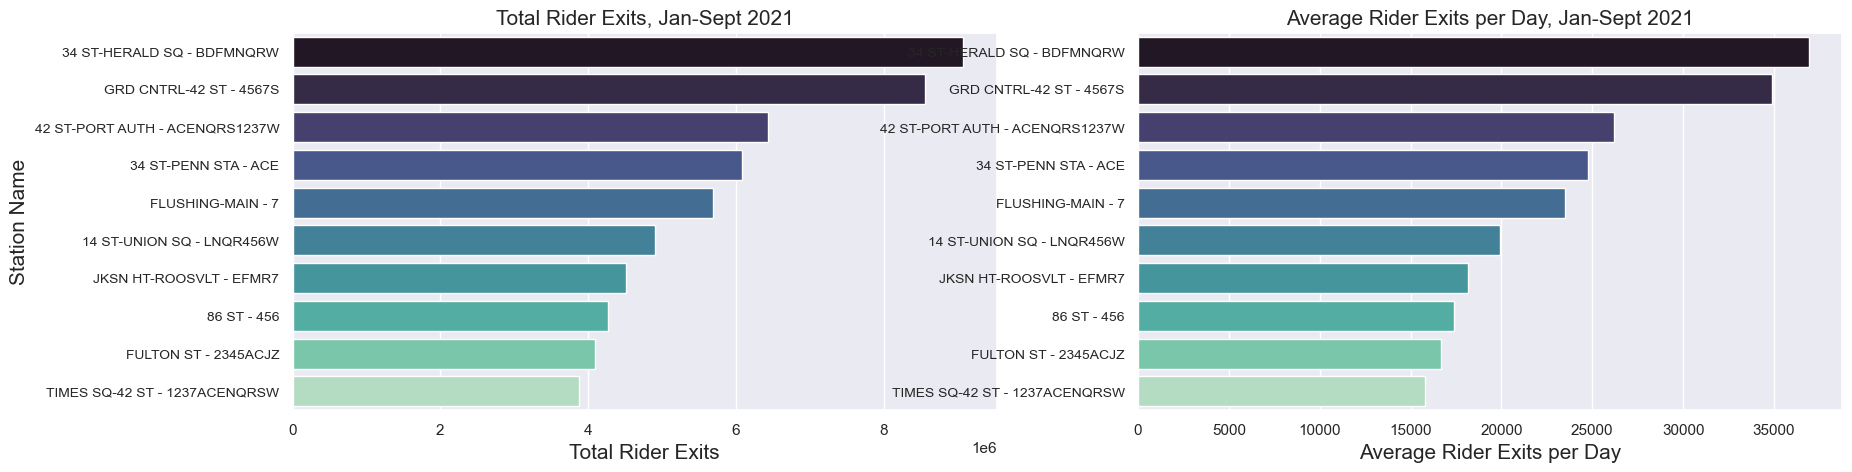

In [32]:
import seaborn as sns

#plot the ridership of our top ten most popular stations
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("darkgrid")

fig, axes = plt.subplots(1,2,figsize=(20,5))
chart = sns.barplot(y=highest_total_ten.station, x=highest_total_ten.station_exits_today, palette="mako", ax=axes[0])
chart.set_yticklabels(chart.get_ymajorticklabels(), fontsize = 10)

chart.set_ylabel('Station Name', fontsize=15)
chart.set_xlabel('Total Rider Exits', fontsize=15)
chart.set_title('Total Rider Exits, Jan-Sept 2021', fontsize=15)

chart2 = sns.barplot(y=highest_average_ten.station, x=highest_average_ten.station_exits_today, 
                     palette="mako", ax=axes[1])
chart2.set_yticklabels(chart2.get_ymajorticklabels(), fontsize = 10)
chart2.set_ylabel('')
chart2.set_xlabel('Average Rider Exits per Day', fontsize=15)
chart2.set_title('Average Rider Exits per Day, Jan-Sept 2021', fontsize=15)


We have hundreds of stations in our data that we're trying to narrow down to a recommendation. We don't want to send the WTWY team to stations that generally sit empty. We'll drop any station that falls below the 50th percentile of average daily ridership. 

In [33]:
lowest_average_ridership = all_df.groupby(['station'],as_index=False)[['station_exits_today']].mean().sort_values(by='station_exits_today',ascending=True)

# add average daily ridership as a column
all_df['station_avg_daily_ridership'] = all_df.groupby(['station']).station_exits_today.transform('mean')

#drop the low ridership stations
high_ridership = all_df[all_df.station_avg_daily_ridership
                        > lowest_average_ridership.station_exits_today.quantile(.5)]

test = high_ridership.groupby(['station']).station_avg_daily_ridership.mean()
test.shape
#239 stations have average daily ridership above the 50th percentile. We'll work with high_ridership from now on 
#and ignore the other stations

#filter our station_by_day dataframe down to just these 239 stations as well 
high_ridership_stations = high_ridership.station.unique()

#this will be our granular dataframe, including period-specific data:
filtered_df = all_df[all_df.station.isin(high_ridership_stations)]
#this will be our dataframe that is grouped by station and less granular: 
station_by_day = station_by_day[station_by_day.station.isin(high_ridership_stations)]

### Activity over time

Now that we're looking at stations with higher ridership, we want to understand what goes on at those stations. When would be best for our team to be there? Let's start with a single station, looking at all 9 months of activity: 

Text(0.5, 1.0, 'Ridership Over Time at 1st Ave Station')

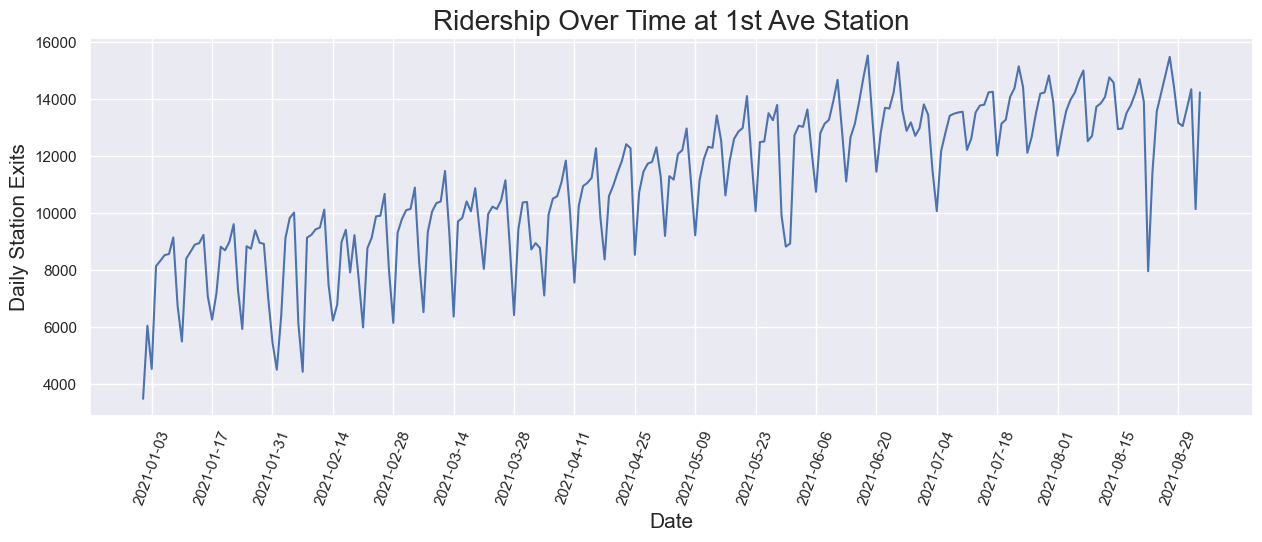

In [34]:
mask = station_by_day[(station_by_day.station=='1 AV - L')]
x1 = mask.date
y1 = mask.station_exits_today
xticks = list(mask.date.dt.date.unique())[2::14]

##this is all the data for this station, where the xticks fall on sundays

sns.set(rc = {'figure.figsize':(15,5)})
plot1 = sns.lineplot(x=x1,y=y1,legend=False)
plot1.set_xticks(xticks)   
plot1.set_xticklabels(labels =xticks, rotation=70)
plot1.set_xlabel('Date', fontsize=15)
plot1.set_ylabel('Daily Station Exits', fontsize=15)
plot1.set_title('Ridership Over Time at 1st Ave Station', fontsize=20)
# does every station follow this trend?

1st Ave station follows a very clear trend of high ridership on weekdays and a lull on weekends. It's possible that this is specific to 1st Ave - do all of New York's stations follow this trend?

(-2916.4500000000003, 100000.0)

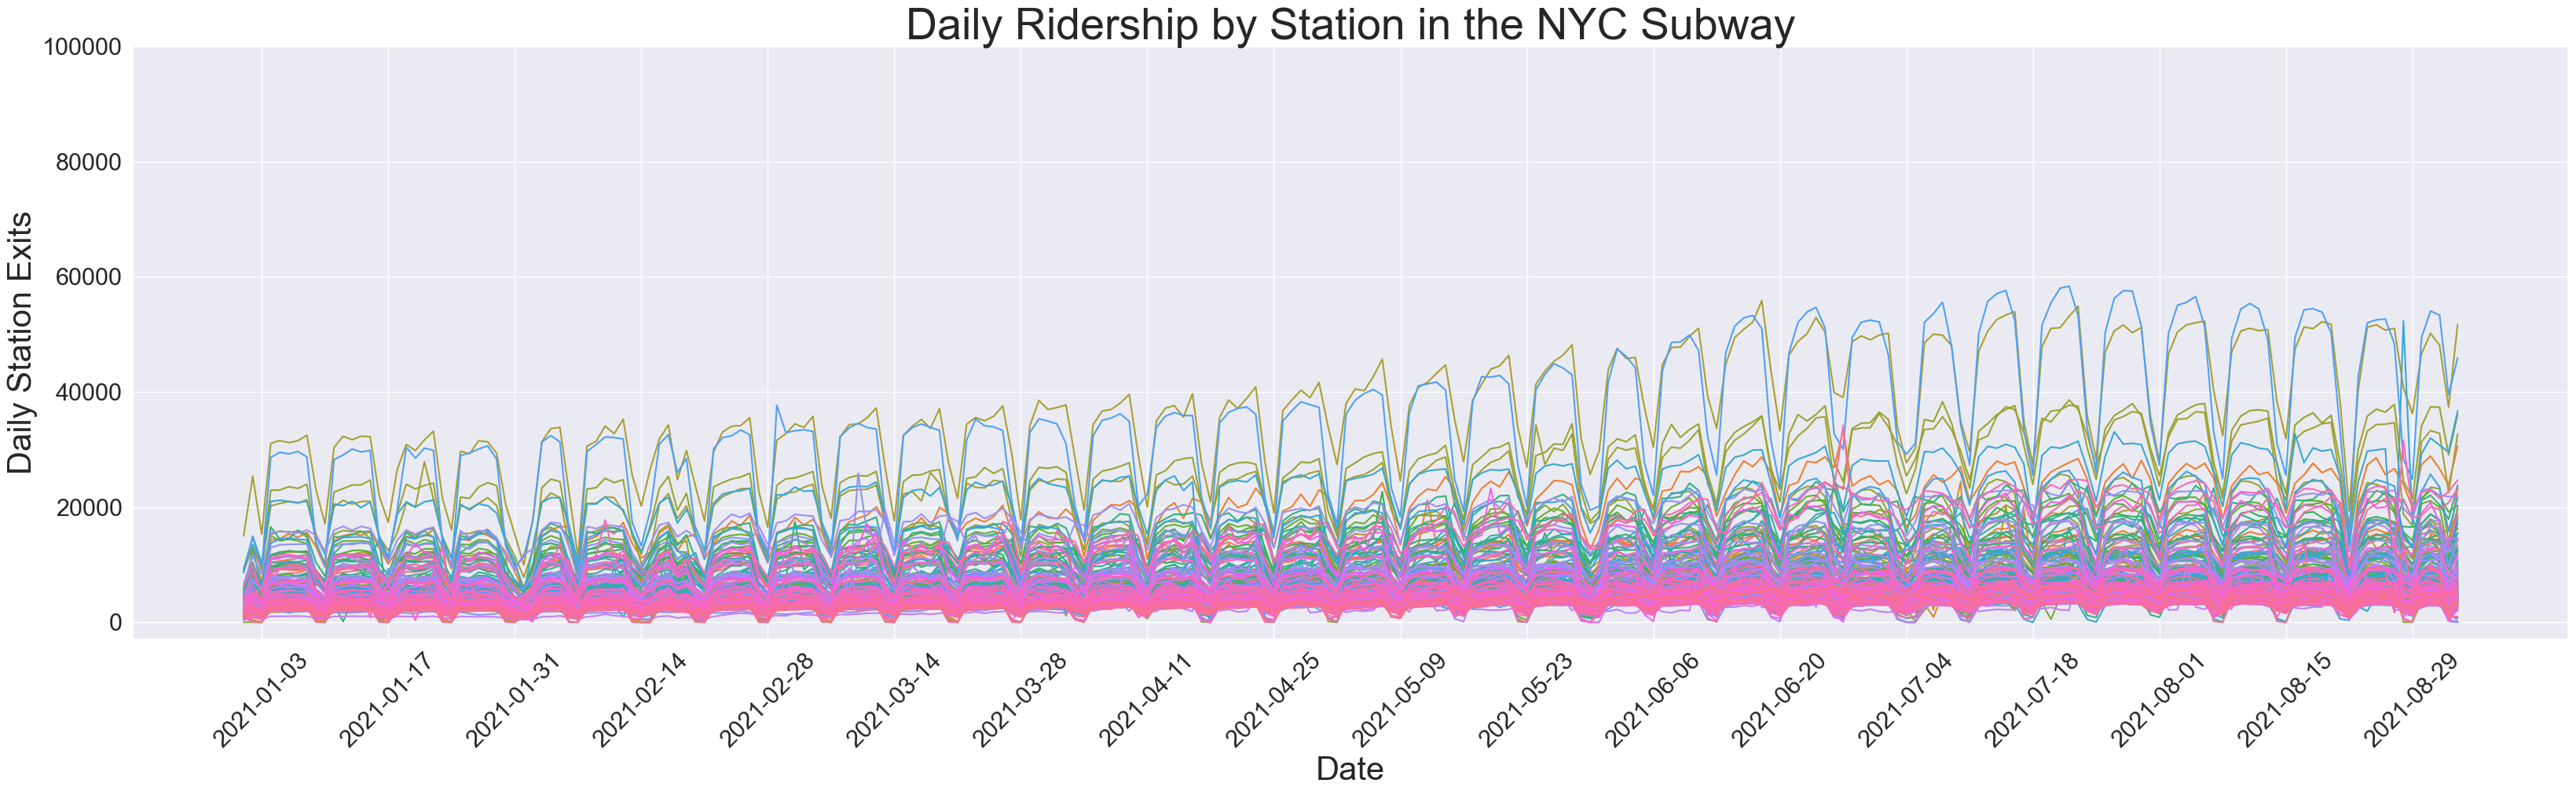

In [35]:
station_list = station_by_day.station.unique()

sns.set(rc={'figure.figsize':(40,10)})
sns.set(font_scale=2)
x = station_by_day.date
y = station_by_day.station_exits_today
station = station_by_day.station
xtick_data=station_by_day.date.dt.date.unique()

    
#set the xticks to start on sunday with 2 week intervals    
plot = sns.lineplot(x=x,y=y, hue=station, legend=False)
plot.set_xticks(xtick_data[2::14])   
plot.set_xticklabels(labels =xtick_data[2::14], rotation=45)
plot.set_xlabel('Date', fontsize=30)
plot.set_ylabel('Daily Station Exits', fontsize=30)
plot.set_title('Daily Ridership by Station in the NYC Subway', fontsize=40)
plt.ylim(top=100000)

    

With some exceptions, it looks like the NYC subway system tends to follow the same pattern of high weekday ridership with a lull on the weekends. Let's focus in on what this looks like day by day. 

### Activity By Day of Week

In [36]:
total_by_day = station_by_day.groupby(['day_of_week'], as_index=False)[['station_exits_today']].sum()
average_per_day = station_by_day.groupby(['day_of_week'], as_index=False)[['station_exits_today']].mean()

In [37]:
import matplotlib.ticker as mticker 

#plot the total ridership by day of the week
days_xlabels= ['Mon','Tues','Weds','Thurs','Fri','Sat','Sun']
f, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5), dpi=1000)
total = sns.barplot(x=total_by_day.day_of_week, y=total_by_day.station_exits_today, ax=ax1, palette="mako")
total.set_xticklabels(days_xlabels, fontsize=15)
total.yaxis.set_major_locator(mticker.FixedLocator(total.get_yticks().tolist()))
total.set_yticklabels(total.get_yticks(), fontsize = 15)
total.set_ylabel('Total Rider Exits Jan-Sept 2021', fontsize=15)
total.set_xlabel('Day of the Week', fontsize=15)
total.set_title('Total Ridership by Day of the Week', fontsize=15)

#plot average daily ridership by day of the week
average = sns.barplot(x=average_per_day.day_of_week, y=average_per_day.station_exits_today, ax=ax2, palette="mako")
average.set_xticklabels(days_xlabels, fontsize=15)
average.yaxis.set_major_locator(mticker.FixedLocator(average.get_yticks().tolist()))
average.set_yticklabels(average.get_yticks(), fontsize = 15)
average.set_ylabel('Average Rider Exits Jan-Sept 2021', fontsize=15)
average.set_xlabel('Day of the Week', fontsize=15)
average.set_title('Average Daily Ridership by Day of the Week', fontsize=15)



Text(0.5, 1.0, 'Average Daily Ridership by Day of the Week')

Here we see another depiction of the weekend lull at NYC subway stations. 

Since we're strategizing based on womens' interactions with schools and daycares, we'll drop the weekends from our analysis and focus on the weekdays. This looks great for ridership, will maximize school days, and is more respectful of the WTWY staff's time. 

In [38]:
#filter both working dfs down to just weekdays
weekdays = filtered_df[(filtered_df.day_of_week >=0) & (filtered_df.day_of_week <=4)]
station_weekdays = station_by_day[(station_by_day.day_of_week >=0) & (station_by_day.day_of_week <=4)]

## Adding Station Coordinate Data

In order to understand the proximity of our stations to schools and daycares, we need to know the station locations. MTA has a dataset that gives latitude and longitude data for each of their stations. Here, we'll read in that data and merge it with our turnstile dataframe. 

In [39]:
stations_orig = pd.read_csv('Stations.csv')
#drop unneeded columns & rename for ease of use
stations_orig=stations_orig.drop(columns=['ADA Notes', 'ADA', 'Structure','North Direction Label', 'South Direction Label'], axis=0)
stations_orig.rename(columns={'Station ID':'station_id', 'Complex ID':'complex_id', 'GTFS Stop ID':'stop_id', 
                'Division':'division', 'Line':'line','Stop Name':'stop_name','Borough':'borough',
                'Daytime Routes':'daytime_routes', 'GTFS Latitude':'latitude',
                'GTFS Longitude':'longitude'}, inplace=True)

stations = stations_orig.copy()
#add line names into station name
stations.stop_name = stations.stop_name.str.strip() + ' - ' + stations.daytime_routes.str.replace(' ', '')
stations.sort_values(by='stop_name').head(3)

station_id  complex_id stop_id division            line   stop_name  \
118         119         119     L06      BMT        Canarsie    1 Av - L   
309         309         309     119      IRT  Broadway - 7Av  103 St - 1   
395         395         395     624      IRT    Lexington Av  103 St - 6   

    borough daytime_routes   latitude  longitude  
118       M              L  40.730953 -73.981628  
309       M              1  40.799446 -73.968379  
395       M              6  40.790600 -73.947478

### Matching Station Names

In order to join the two tables, we need to match them on a unique identifier, which in this case is the combination of station name and line. We will have to use multiple strategies in order to get as many stations matched as possible. 

In [40]:
#STRATEGY 1
#matching station names that are already the same
station_names_filtered_df = sorted(filtered_df.station.str.strip().unique())
stop_names_station_data = sorted(stations.stop_name.str.strip().str.upper())

station_dict = {}

#run through the dataframe, check if the station is in the other dataframe,
#and if it is, mark True in the dictionary. Otherwise false. 
for idx, station in enumerate(station_names_filtered_df):
    if station in stop_names_station_data:
        station_dict[station] = True
    else:
        station_dict[station] = False

#group together all of the entries that were False- meaning they weren't 
#found in both dataframes
did_not_work = [k for k,v in station_dict.items() if v==False]

#these are the options left of names to match
stop_names_left = [x for x in stop_names_station_data if x not in station_dict.keys()]

# for the first batch that worked automatically, replace them in the stations dataframe with the MTA dataset name
for index, row in stations.iterrows():
    stop_name = row.stop_name.strip().upper()
    if stop_name in station_dict:
        stations.at[index, 'match_stop_name'] = stop_name

print('All Station Names:', len(station_dict))
print('Successfully Matched:', 239-len(did_not_work))

All Station Names: 239
Successfully Matched: 114


In [41]:
#STRATEGY 2
#Fuzzy matching strings that are somewhat similar

from fuzzywuzzy import process, fuzz
match_dict = {}

#loop thru the stations that weren't found before, and find the station
#in the other dataframe that it's most similar to. If its similarity is 
#above a certain threshold, add it to our list

for station in did_not_work:
    highest = process.extractOne(station, stop_names_left)
    if highest[1] >= 90:
        match_dict[station] = highest[0]
        
print('Successfully matched with this strategy:',len(match_dict))
print('Matched so far:', (239-len(did_not_work)+len(match_dict)))

# Now replace these names in the stations dataframe before dealing with the rest of the unmatched

for index, row in stations.iterrows():
    stop_name = row.stop_name.strip().upper()
    for station, stop in match_dict.items() :
        if stop_name == stop:
            stations.at[index, 'match_stop_name'] = station

Successfully matched with this strategy: 58
Matched so far: 172


In [42]:
#how many unmatched names are left?
for key in match_dict.keys():
    station_dict[key] = True 
    
still_unmatched = [k for k,v in station_dict.items() if v==False ]
print('Still Unmatched:',len(still_unmatched))

Still Unmatched: 67


For these last 67, we need to fill in the names manually based on what we know of both datasets. Not all 67 were able to be matched, but we completed the majority of the remaining station matches. 

In [43]:
final_unmatched_dict = {'14TH STREET - 123FLM': '14 St - FM',
                        '14 ST - FLM123': '14 St - FM',
                        '149/GRAND CONC - 245': '149 St-Grand Concourse - 25',
                        '161/YANKEE STAD - BD4': '161 St-Yankee Stadium - BD',
                        '34 ST-PENN STA - 123ACE': '34 St-Penn Station - 123',
                        '42 ST-PORT AUTH - ACENGRS1237W': '42 St-Port Authority Bus Terminal - ACE',
                        '47-50 STS ROCK - BDFM': '47-50 Sts-Rockefeller Ctr - BDFM',
                        '4AV-9 ST - DFGMNR': '4 Av-9 St - R',
                        '5 AVE - 7BDFM': '5 Av - 7',  
                        '59 ST - 456NQRW': '59 St - 456',
                        '59 ST - NQR456W': '59 St - 456',
                        '59 ST COLUMBUS - 1ABCD': '59 St-Columbus Circle - ABCD',
                        '59 ST COLUMBUS - ABCD1': '59 St-Columbus Circle - ABCD',
                        '68ST-HUNTER CO - 6': '68 St-Hunter College - 6',
                        '72 ST-2 AVE - Q':'72 St - Q', 
                        '8 AV - ACEL' : '8 Av - L',
                        '81 ST-MUSEUM - BC': '81 St-Museum of Natural History - BC',
                        '86 ST-2 AVE - Q':'86 St - Q', 
                        '96 ST-2 AVE - Q':'96 St - Q', 
                        'ASTORIA DITMARS - NQW': 'Astoria-Ditmars Blvd - NW',   
                        'ATL AV-BARCLAY - 2345BDNQR':'Atlantic Av-Barclays Ctr - 2345',
                        'ATL AV-BARCLAY - BDNQR2345': 'Atlantic Av-Barclays Ctr - 2345',
                        "B'WAY-LAFAYETTE - BDFQ6":'Broadway-Lafayette St - BDFM',
                        'BEDFORD-NOSTRAN - G':'Bedford-Nostrand Avs - G',
                        'BROADWAY JCT - ACJLZ':'Broadway Junction - AC', 
                        'BROOKLYN BRIDGE - 456JZ': 'Brooklyn Bridge-City Hall - 456',
                        'CANAL ST - JNQRZ6W': 'Canal St - NQ',
                        'CATHEDRAL PKWY - 1': 'Cathedral Pkwy (110 St) - 1',
                        'CENTRAL PK N110 - 23': 'Central Park North (110 St) - 23',
                        'CHRISTOPHER ST - 1': 'Christopher St-Sheridan Sq - 1',
                        'CONEY IS-STILLW - DFNQ': 'Coney Island-Stillwell Av - DFNQ',
                        'DELANCEY/ESSEX - FJMZ': 'Delancey St-Essex St - JMZ',
                        'FLATBUSH AV-B.C - 25': 'Flatbush Av-Brooklyn College - 25',
                        'FRANKLIN AV - 2345S': 'Franklin Avenue-Medgar Evers College - 2345',
                        'FULTON ST - 2345ACJZ': 'Fulton St - AC',
                        'FULTON ST - ACJZ2345': 'Fulton St - AC',
                        'GRD CNTRL-42 ST - 4567S': 'Grand Central-42 St - 456',
                        'HOYT-SCHER - ACG':'Hoyt-Schermerhorn Sts - ACG',
                        'JAMAICA CENTER - EJZ': 'Jamaica Center-Parsons/Archer - EJZ',
                        'JFK JAMAICA CT1 - E': 'Jamaica-Van Wyck - E',
                        'JKSN HT-ROOSVLT - EFMR7': 'Jackson Hts-Roosevelt Av - EFMR',
                        'KEW GARDENS - EF': 'Kew Gardens-Union Tpke - EF',
                        'MORISN AV/SNDVW - 6': 'Morrison Av-Soundview - 6',
                        'MYRTLE-WYCKOFF - LM': 'Myrtle-Wyckoff Avs - L',
                        'OZONE PK LEFFRT - A':'Ozone Park-Lefferts Blvd - A',
                        'SUTPHIN-ARCHER - EJZ': 'Sutphin Blvd-Archer Av-JFK Airport - EJZ',
                        'SUTTER AV-RUTLD - 3': 'Sutter Av-Rutland Rd - 3',
                        'THIRTY ST - 1':'30 Av - NW',  
                        'THIRTY THIRD ST - 1': '33 St - 6',
                        'TIMES SQ-42 ST - 1237ACENQRS': 'Times Sq-42 St - 123',
                        'TIMES SQ-42 ST - 1237ACENQRSW': 'Times Sq-42 St - 123',
                        'TIMES SQ-42 ST - ACENQRS1237W': 'Times Sq-42 St - 123',
                        'WEST FARMS SQ - 25': 'West Farms Sq-E Tremont Av - 25',
                        'WESTCHESTER SQ - 6': 'Westchester Sq-E Tremont Av - 6',
                        'WHITEHALL S-FRY - R1W':'Whitehall St-South Ferry - RW',
                        'WORLD TRADE CTR - ACE23': 'World Trade Center - E'}

In [44]:
# Replace those final stations:
for index, row in stations.iterrows():
    stop_name = row.stop_name.strip()
    for station, stop in final_unmatched_dict.items() :
        if stop_name == stop:
            stations.at[index, 'match_stop_name'] = station
       
    
#drop stations that couldn't be matched
final_stations = stations.dropna(axis=0, subset=['match_stop_name'])
final_stations.head(200).sort_values(by='match_stop_name')

print('Final successful matches:',final_stations.shape[0])

Final successful matches: 215


### Joining Station Location Data with MTA Turnstiles 

Now that the names are matched up, we can join the dataframes together to merge our turnstile data with the station coordinates. 

In [45]:
merged_df = pd.merge(weekdays,final_stations,left_on='station',right_on='match_stop_name')
merged_station_by_day = pd.merge(station_weekdays,final_stations,left_on='station',right_on='match_stop_name')

merged_station_by_day.sample(5)

station       date  day_of_week  station_entries_today  \
32182     OZONE PK LEFFRT - A 2021-08-13            4                 3347.0   
14779       81 ST-MUSEUM - BC 2021-01-07            3                 2677.0   
22137  CONEY IS-STILLW - DFNQ 2021-07-26            0                 7979.0   
3110            145 ST - ABCD 2021-06-16            2                 9249.0   
26709            HIGH ST - AC 2021-07-21            2                 3347.0   

       station_exits_today  real_entries_since_audit  real_exits_since_audit  \
32182               3503.0                    3347.0                  3503.0   
14779               3005.0                    2677.0                  3005.0   
22137               8197.0                    7979.0                  8197.0   
3110               12518.0                    9249.0                 12518.0   
26709               5156.0                    3347.0                  5156.0   

       station_id  complex_id stop_id division  \
32182         195         195     A65      IND   
14779         159         159     A21      IND   
22137          58          58     D43      BMT   
3110          153         153     A15      IND   
26709         173         173     A40      IND   

                                           line  \
32182                                Liberty Av   
14779                        8th Av - Fulton St   
22137  Sea Beach / West End / Culver / Brighton   
3110                         8th Av - Fulton St   
26709                        8th Av - Fulton St   

                                  stop_name borough daytime_routes   latitude  \
32182          Ozone Park-Lefferts Blvd - A       Q              A  40.685951   
14779  81 St-Museum of Natural History - BC       M            B C  40.781433   
22137      Coney Island-Stillwell Av - DFNQ      Bk        D F N Q  40.577422   
3110                          125 St - ABCD       M        A B C D  40.811109   
26709                          High St - AC      Bk            A C  40.699337   

       longitude         match_stop_name  
32182 -73.825798     OZONE PK LEFFRT - A  
14779 -73.972143       81 ST-MUSEUM - BC  
22137 -73.981233  CONEY IS-STILLW - DFNQ  
3110  -73.952343           145 ST - ABCD  
26709 -73.990531            HIGH ST - AC

## Adding in School & Daycare Data

Next, we need to read in the latitude and longitude data for schools and daycares in order to calculate the proximity between them and our stations. We'll filter both datasets down to just the facilities that are open and relevant to our analysis (i.e. filter out high schoolers who don't get picked up, filter out closed daycares). 

In [46]:
import geopy

daycares = pd.read_csv('Child_Care_Regulated_Programs.csv')
schools = pd.read_csv('2019_-_2020_School_Locations.csv')

pd.options.display.max_columns = 100

#drop any rows that don't have lat/long data, as well as unneeded columns
daycares.dropna(axis=0, subset=['Latitude','Longitude'], inplace=True)
daycares.drop(axis=1, labels=['Program Profile','Total Capacity','School Age Capacity',
                               'Preschool Capacity', 'Toddler Capacity','Infant Capacity',
                               'Capacity Description', 'Provider Name','Phone Extension',
                               'Phone Number','Phone Number Omitted','Apartment', 'Floor',
                               'Additional Address', 'Address Omitted', 'License Expiration Date',
                               'License Issue Date', 'Facility Opened Date', 'County'], inplace=True)

#filter out daycares that aren't approved
daycares = daycares[(daycares['Region Code'] == 'NYCDOH') & 
                   (daycares['Facility Status'] != 'PENDING REVOCATION') &
                   (daycares['Facility Status'] != 'PENDING REVOCATION & DENIAL') &
                   (daycares['Facility Status'] != 'PENDING DENIAL') &
                   (daycares['Facility Status'] != 'SUSPENDED')]

daycares.drop_duplicates(subset=['Facility Name'],inplace=True)
print(daycares.shape)
daycares.head(3)

(7075, 14)


Facility ID Program Type Region Code Facility Status  \
11       180842         SACC      NYCDOH    Registration   
13       221580          FDC      NYCDOH    Registration   
14       227440         SACC      NYCDOH    Registration   

                                        Facility Name Street Number  \
11               Queens Community House, Inc. @ PS 86         87-41   
13                                   Calderon, Benita          1982   
14  Sesame Flyers International, Inc Bildersee Bea...           956   

      Street Name      City State  Zip Code School District Name   Latitude  \
11   Parsons Blvd   Jamaica    NY     11432            Queens 28  40.709095   
13  WALTON AVENUE     BRONX    NY     10453              Bronx 9  40.851936   
14    E. 82nd St.  Brooklyn    NY     11236          Brooklyn 18  40.635440   

    Longitude                  Georeference  
11 -73.803887  POINT (-73.803887 40.709095)  
13 -73.907683  POINT (-73.907683 40.851936)  
14 -73.910885   POINT (-73.910885 40.63544)

In [47]:
#drop unneeded columns
schools.drop(axis=1, labels=['Managed_by_name','fiscal_year','system_code','BEDS','open_date',
                            'Primary_building_code', 'X_COORDINATE','Y_COORDINATE', 'Community_district',
                            'Council-district','Census_tract','Borough_block_lot', 'NTA', 'NTA_Name',
                            'Principal_Name','Principal_title','Principal_phone_number','fax_number',
                            'Geographical_District_code', 'Administrative_District_Code', 'Administrative_District_Name',
                            'community_school_sup_name', 'Tier_3_Support_Location_Name','Tier_3_Support_Leader_Name',
                            'Tier_2_Support_Location_Name', 'HighSchool_Network_Location_Code', 'HighSchool_Network_Name',
                            'HighSchool_Network_Superintendent','Community_district 1', 'Police_precinct'], inplace=True)

schools.drop_duplicates(subset = ['location_name'],inplace=True)

#only keep open schools that teach ages that may need to be picked up from school 
schools = schools.copy()[(schools.Status_descriptions == 'Open') & 
                        ((schools.Location_Category_Description == 'Elementary') |
                        (schools.Location_Category_Description == 'K-8')|
                        (schools.Location_Category_Description == 'K-12 all grades')|
                        (schools.Location_Category_Description == 'Early Childhood'))]
print(schools.shape)
schools.head(3)

(1027, 11)


location_code                 location_name location_type_description  \
0          K001           P.S. 001 The Bergen          General Academic   
2          K003  P.S. 003 The Bedford Village          General Academic   
3          K004                     P.S. K004         Special Education   

  Location_Category_Description              Grades_text  \
0                    Elementary  PK,0K,01,02,03,04,05,SE   
2                    Elementary  PK,0K,01,02,03,04,05,SE   
3                    Elementary  PK,0K,01,02,03,04,05,SE   

               Grades_final_text Status_descriptions primary_address_line_1  \
0           PK,0K,01,02,03,04,05                Open          309 47 STREET   
2           PK,0K,01,02,03,04,05                Open    50 JEFFERSON AVENUE   
3  PK,0K,01,02,03,04,05,06,07,SE                Open      923 JEROME STREET   

  State_code  LONGITUDE   LATITUDE  
0         NY -74.011420  40.648959  
2         NY -73.955219  40.682311  
3         NY -73.879276  40.658500

In [48]:
#combine schools and daycares into one dataframe

simple_daycares = daycares[['Facility Name', 'Latitude','Longitude']]
simple_schools = schools[['location_name','LATITUDE','LONGITUDE']]
simple_daycares = simple_daycares.rename({'Facility Name':'facility_name', 'Latitude':'latitude', 
                                          'Longitude':'longitude'}, axis=1)
simple_schools = simple_schools.rename({'location_name':'facility_name', 'LATITUDE':'latitude', 
                                        'LONGITUDE':'longitude'}, axis=1)

schools_daycares = pd.concat([simple_daycares, simple_schools])

schools_daycares['coordinate'] = list(zip(schools_daycares['latitude'], schools_daycares['longitude']))
schools_daycares['coordinate'] = tuple(schools_daycares['coordinate'])
schools_daycares.head()

facility_name   latitude  longitude  \
11               Queens Community House, Inc. @ PS 86  40.709095 -73.803887   
13                                   Calderon, Benita  40.851936 -73.907683   
14  Sesame Flyers International, Inc Bildersee Bea...  40.635440 -73.910885   
19                                     Fernandez, Luz  40.839556 -73.868169   
20                                Big Apple Institute  40.590642 -73.974855   

                 coordinate  
11  (40.709095, -73.803887)  
13  (40.851936, -73.907683)  
14   (40.63544, -73.910885)  
19  (40.839556, -73.868169)  
20  (40.590642, -73.974855)

### Formatting station data for location calculations

In [49]:
merged_df['coordinate'] = list(zip(merged_df.latitude, merged_df.longitude))
merged_df['coordinate'] = tuple(merged_df.coordinate)
merged_df.head()

station_coords = merged_df.drop_duplicates(subset='coordinate')[['station', 'coordinate']]
station_coords.head(3)


station               coordinate
0        1 AV - L  (40.730953, -73.981628)
25685  103 ST - 1  (40.799446, -73.968379)
32017  103 ST - 6    (40.7906, -73.947478)

## Finding Proximities using Geopy

To find distances between subway stations, schools, and daycares, we will use geopy.distance, which allows us to input two coordinates in order to calculate the distance between them in miles. The distance that is returned is 'as the bird flies,' so walking there would be a bit longer. 

In [50]:
from geopy import distance

schools_daycares.dropna(subset=['latitude','longitude'], axis = 0, inplace=True)
station_coords.dropna(subset=['coordinate'], axis=0, inplace=True)

schools_daycares.isnull().value_counts()
#keep in mind this distance will be as the bird flies

#create lists of coordinates from both dataframes
station_list = station_coords.values.tolist()
to_daycare_list = schools_daycares[['facility_name', 'coordinate']]
school_daycare_list = to_daycare_list.values.tolist()


In [51]:
#run through both lists of coordinates to find proximities, and create a new dataframe
#with the distances in miles for each pair of locations

list_to_df = []

for stat_row in station_list:
    station_coord = stat_row[1]
    station_name = stat_row[0]
    for school_row in school_daycare_list:
        school_coord = school_row[1]
        school_name = school_row[0]
        
        distance_between = distance.distance(station_coord,school_coord).miles
        
        list_to_df.append([station_name, school_name, distance_between])
        
distances_df = pd.DataFrame(list_to_df)
distances_df.rename({0:'station', 1:'school_daycare', 2:'distance'}, axis=1, inplace=True)
distances_df.head(3)

station                                     school_daycare  distance
0  1 AV - L               Queens Community House, Inc. @ PS 86  9.452466
1  1 AV - L                                   Calderon, Benita  9.204950
2  1 AV - L  Sesame Flyers International, Inc Bildersee Bea...  7.566019

Now that we've calculated the distances, we want to only work with subway stations that are close enough to schools & daycares that it could make a difference for the WTWY team. We'll filter the data down to any facility/station pair that have 0.3 miles or less between them. 

Below, we filter the data by that .3 miles and then aggregate it to count the number of facilities nearby each station. 

In [52]:
distances_df.sort_values(by='distance', ascending=True)
#filter down to only station/facility pairs within .3 miles of each other
close_together = distances_df[distances_df.distance <= .3]
close_together_counts = close_together.station.value_counts()

#aggregate the number of nearby facilities for each station
close_together_counts = pd.DataFrame(close_together_counts).reset_index()
close_together_counts.rename({'index':'station_name_proximity_df', 'station':'number_of_close_facilities'},axis=1, inplace=True)
close_together_counts[:5]

station_name_proximity_df  number_of_close_facilities
0                170 ST - 4                         104
1           FORDHAM RD - BD                         100
2                167 ST - 4                          97
3           BURNSIDE AV - 4                          97
4           TREMONT AV - BD                          95

Text(0.5, 0, 'Number of Nearby Schools/Daycares')

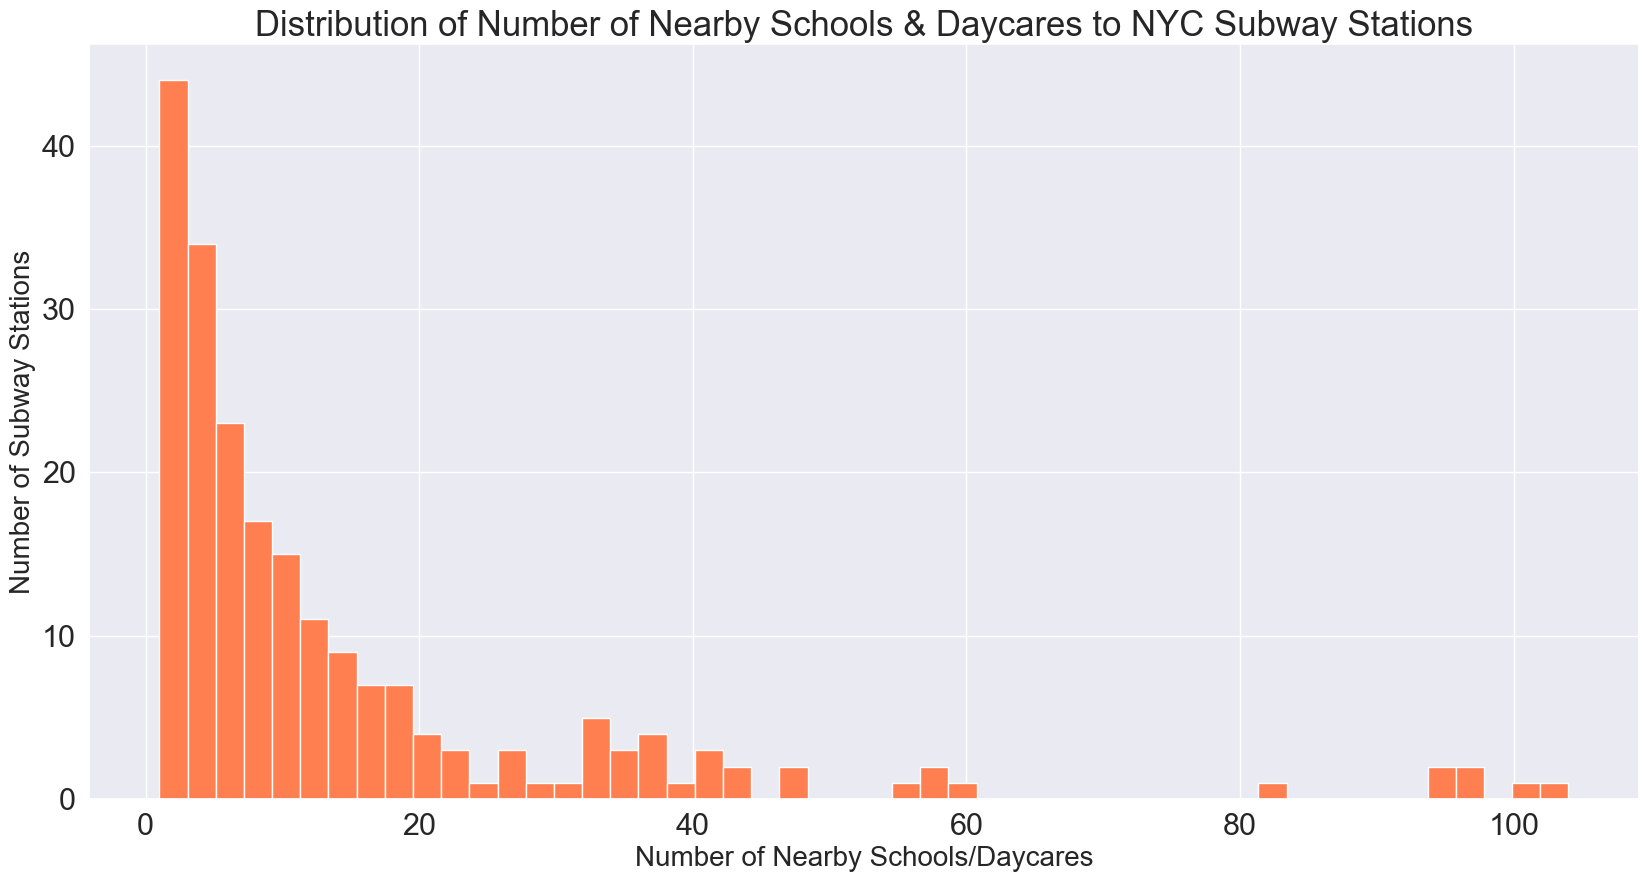

In [53]:
#plot the distribution of nearby facilities to our subway stations
plt.figure(figsize=(20,10))
plt.hist(close_together_counts.number_of_close_facilities, bins=50, color = 'coral')

plt.title('Distribution of Number of Nearby Schools & Daycares to NYC Subway Stations', fontsize=25)
plt.ylabel('Number of Subway Stations', fontsize=20)
plt.xlabel('Number of Nearby Schools/Daycares', fontsize=20)

In [54]:
#add the number of nearby facilities into our dataframe
counts_and_ridership = pd.merge(close_together_counts, weekdays, left_on='station_name_proximity_df', right_on='station')
counts_and_ridership.sample(3)

station_name_proximity_df  number_of_close_facilities    ca  unit  \
986452                 46 ST - MR                           9  N316  R267   
2538607            CANAL ST - ACE                           2  N090  R139   
2999979                 69 ST - 7                           1  R524  R347   

              scp         station line_name       date      time     desc  \
986452   00-00-01      46 ST - MR        MR 2021-02-04  12:00:00  REGULAR   
2538607  01-00-00  CANAL ST - ACE       ACE 2021-08-16  04:00:00  REGULAR   
2999979  00-00-00       69 ST - 7         7 2021-05-17  01:00:00  REGULAR   

         entries     exits           date_time  entries_since_last_audit  \
986452    377782    282026 2021-02-04 12:00:00                      62.0   
2538607  1388722  14161372 2021-08-16 04:00:00                       1.0   
2999979  9904148   9202861 2021-05-17 01:00:00                      10.0   

         exits_since_last_audit  real_entries_since_audit  \
986452                     66.0                      62.0   
2538607                     7.0                       1.0   
2999979                    80.0                      10.0   

         real_exits_since_audit  day_of_week  station_entries_today  \
986452                     66.0            3                 2903.0   
2538607                     7.0            0                 5039.0   
2999979                    80.0            0                 2457.0   

         station_exits_today  station_avg_daily_ridership  
986452                4154.0                  3143.073661  
2538607               7122.0                  5632.407927  
2999979               3238.0                  2968.827363

## Choosing the best stations 

Here is a look at all the stations in play, plotted by their nearby facility count and their daily ridership:

Text(0.5, 1.0, 'Ridership and Proximity to Childcare Facilities at NYC Subway Stations')

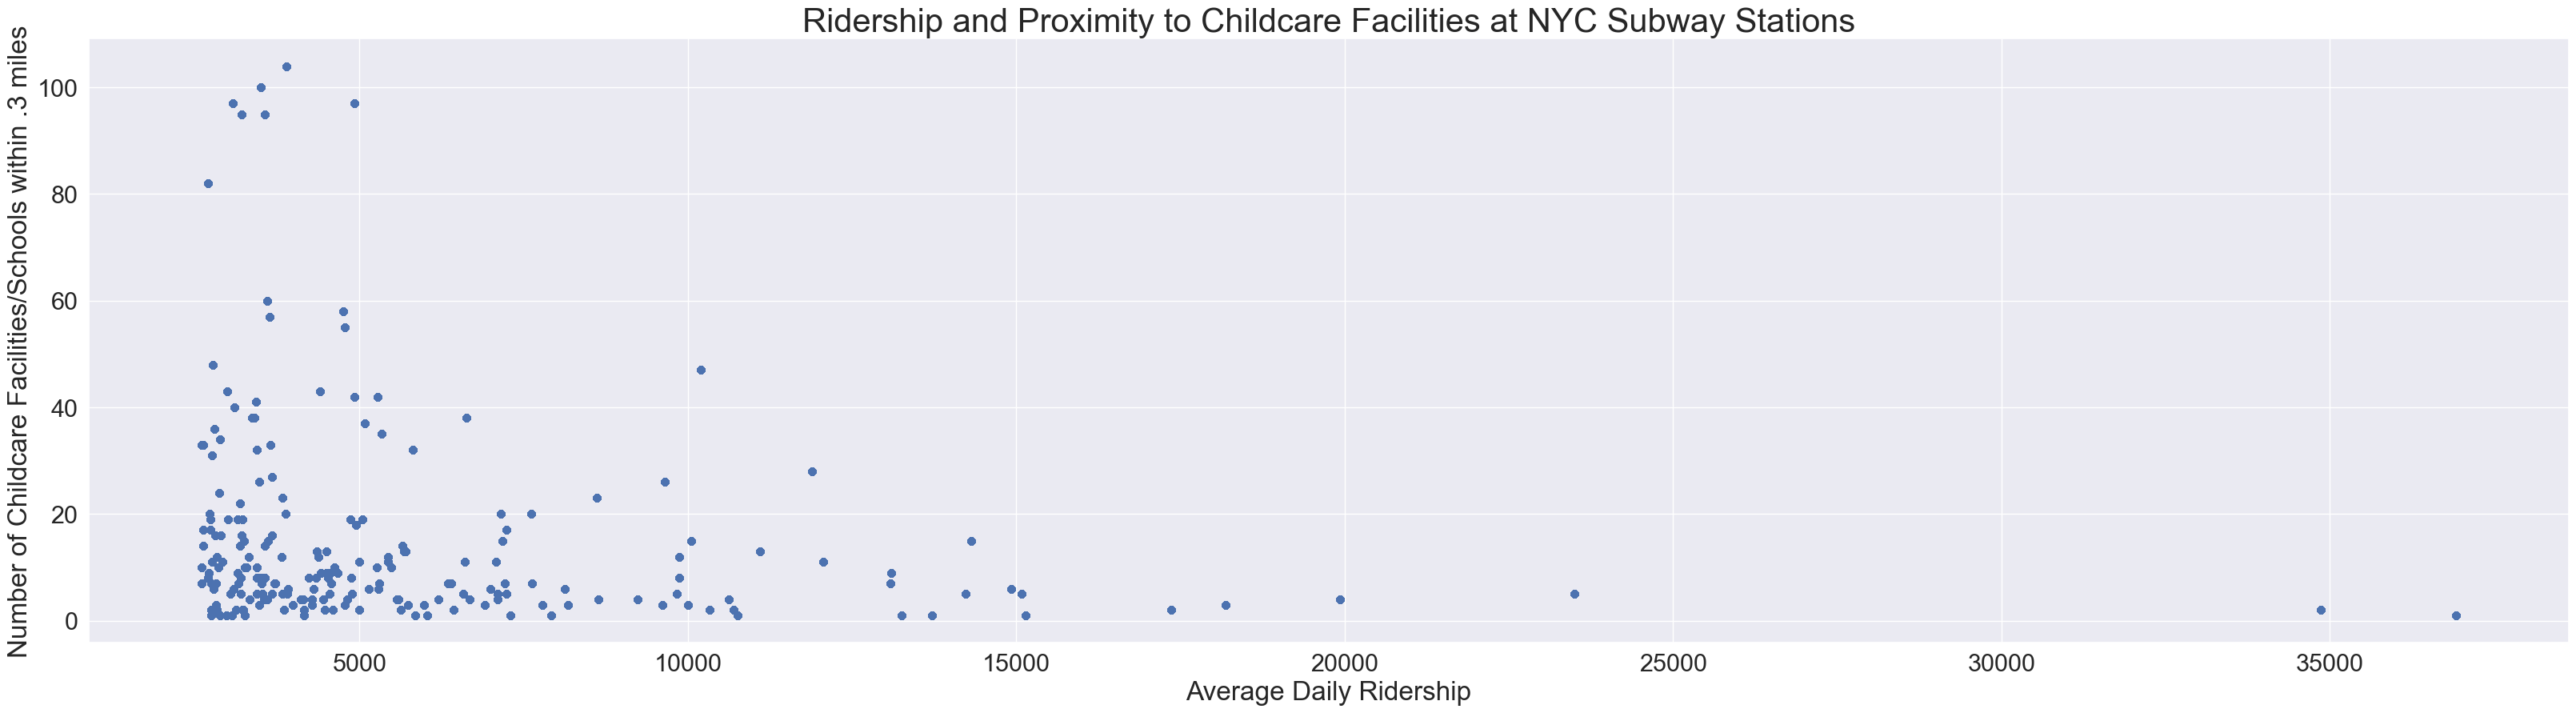

In [55]:
plt.scatter(counts_and_ridership.station_avg_daily_ridership, counts_and_ridership.number_of_close_facilities)
plt.xlabel('Average Daily Ridership')
plt.ylabel('Number of Childcare Facilities/Schools within .3 miles')
plt.title('Ridership and Proximity to Childcare Facilities at NYC Subway Stations', fontsize=30)

We're going to filter this down to just 12 stations, which are the best options for the team. We'll choose both ideal stations, with relatively high ridership and facilities counts, as well as a few stations that have extremely high facilities counts:

Text(0.5, 1.0, 'Ridership and Proximity to Childcare Facilities at NYC Subway Stations')

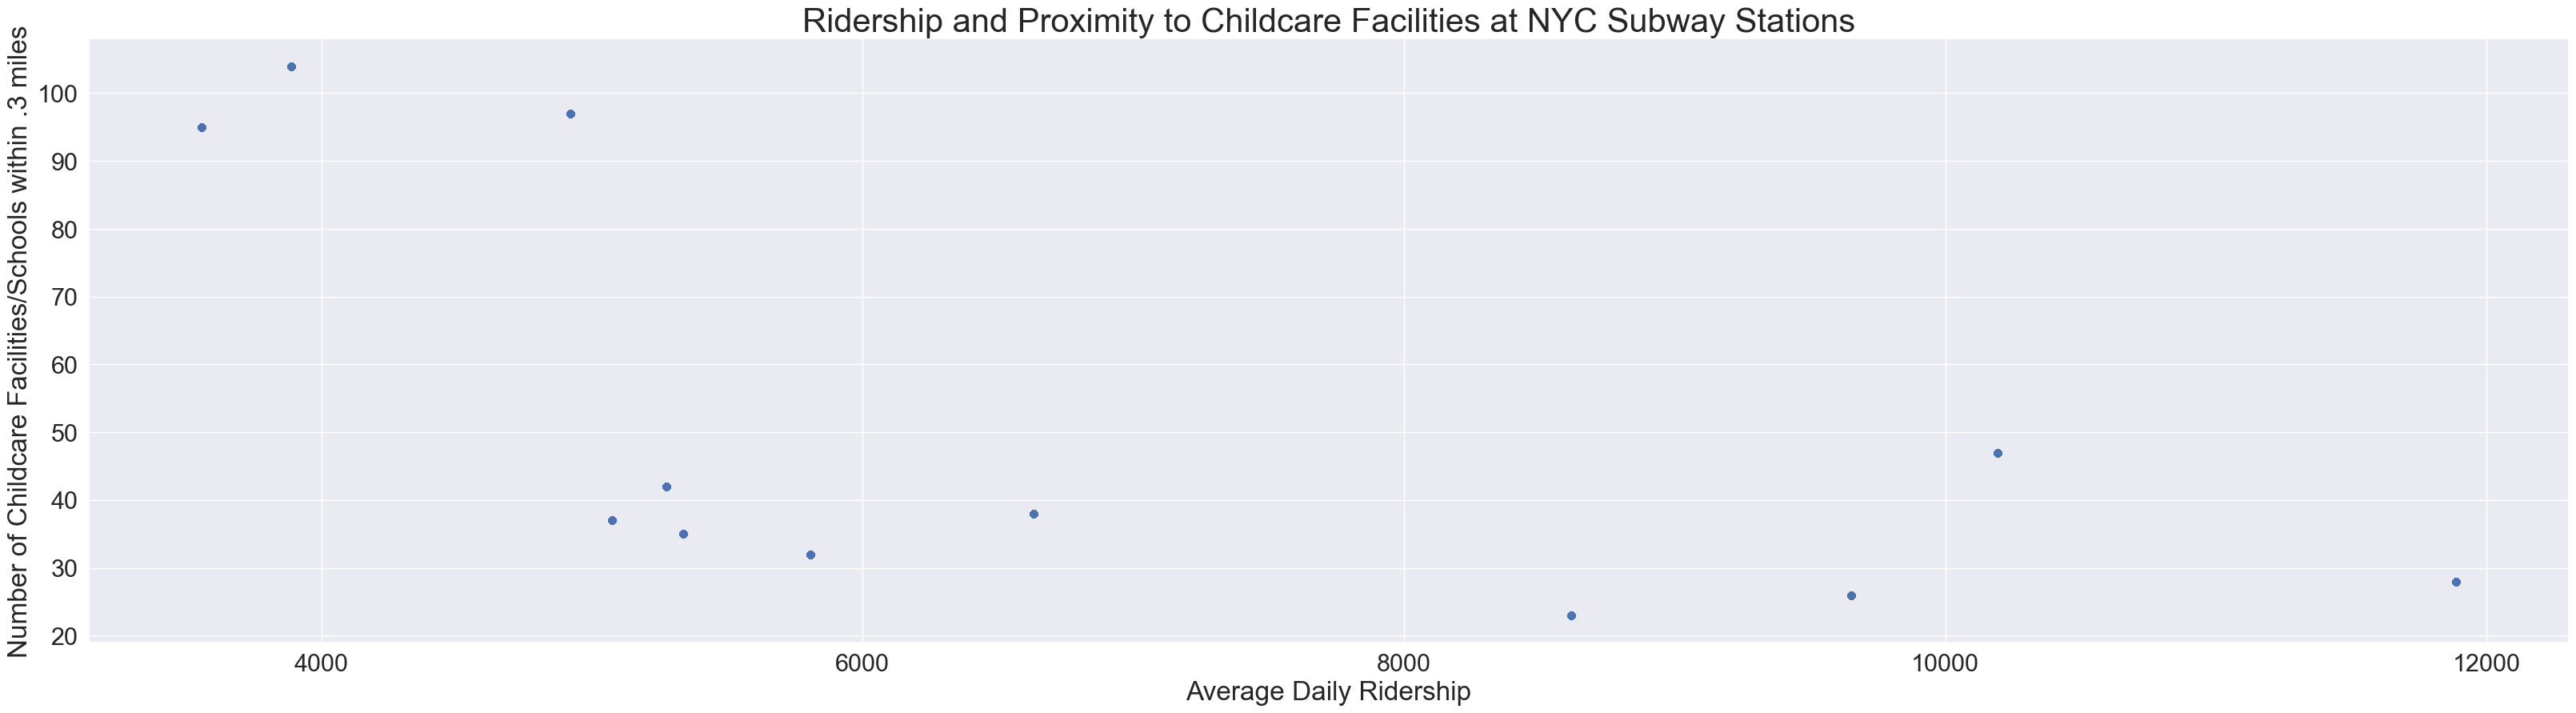

In [56]:
best_options = counts_and_ridership[((counts_and_ridership.station_avg_daily_ridership>5000) &
                                   (counts_and_ridership.number_of_close_facilities>20)) | 
                                   ((counts_and_ridership.number_of_close_facilities>80) &
                                    (counts_and_ridership.station_avg_daily_ridership>3500))]

#also including lower-ridershp stations with huge facilities 
#numbers becuse they'll get exposure to those who may not come from the subway
plt.scatter(best_options.station_avg_daily_ridership, best_options.number_of_close_facilities)
plt.xlabel('Average Daily Ridership')
plt.ylabel('Number of Childcare Facilities/Schools within .3 miles')
plt.title('Ridership and Proximity to Childcare Facilities at NYC Subway Stations', fontsize=30)

In [57]:
#show a dataframe of our top station options
grouped_best_options = best_options.groupby('station', as_index=False)[['number_of_close_facilities', 
                                 'station_avg_daily_ridership']].max().sort_values('station_avg_daily_ridership', ascending=False)
grouped_best_options

station  number_of_close_facilities  \
2            125 ST - 456                          28   
4           145 ST - ABCD                          47   
9   DELANCEY/ESSEX - FJMZ                          26   
10          GRAND ST - BD                          23   
8        3 AV-149 ST - 25                          38   
0              103 ST - 6                          32   
3     137 ST CITY COL - 1                          35   
7              181 ST - A                          42   
1              116 ST - 6                          37   
5              167 ST - 4                          97   
6              170 ST - 4                         104   
11        TREMONT AV - BD                          95   

    station_avg_daily_ridership  
2                  11886.495650  
4                  10193.049457  
9                   9652.643205  
10                  8618.357083  
8                   6631.727738  
0                   5807.738983  
3                   5336.948315  
7                   5273.983811  
1                   5074.432359  
5                   4921.591063  
6                   3888.823052  
11                  3556.778222

## Time of day at chosen stations

To help the WTWY team optimize their schedule, we'll want to understand what each time of day looks like at our top 12 stations. That way, we can prioritize certain stations at certain times. 

In [58]:
station_options = best_options.station.unique()
time_of_day = weekdays[np.isin(weekdays.station, station_options)]

In [59]:
midnight, four, eight, noon, sixteen, twenty, twentyfour = dt.time(0,0), dt.time(4,0), dt.time(8,0), dt.time(12,0), dt.time(16,0), dt.time(20,0), dt.time(23,59)

def get_timeblock(time):
    if (time >= midnight) & (time < four):
        return '00:00 - 04:00' 
    elif (time >= four) & (time < eight):
        return '04:00 - 08:00'
    elif (time >= eight) & (time < noon):
        return '08:00 - 12:00'
    elif (time >= noon) & (time < sixteen):
        return '12:00 - 16:00'
    elif (time >= sixteen) & (time < twenty):
        return '16:00 - 20:00'
    elif (time >= twenty) & (time <= twentyfour):
        return '20:00 - 24:00'

time_of_day['time_block'] = time_of_day.time.apply(get_timeblock)
      
grouped_time = time_of_day.groupby(['station','time_block'], as_index=False)[['real_exits_since_audit']].mean()
grouped_time.head(5)



station     time_block  real_exits_since_audit
0  103 ST - 6  00:00 - 04:00               92.019048
1  103 ST - 6  04:00 - 08:00               12.767045
2  103 ST - 6  08:00 - 12:00              256.042373
3  103 ST - 6  12:00 - 16:00              238.065341
4  103 ST - 6  16:00 - 20:00              269.044762

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Average Station Ridership per Time Period')

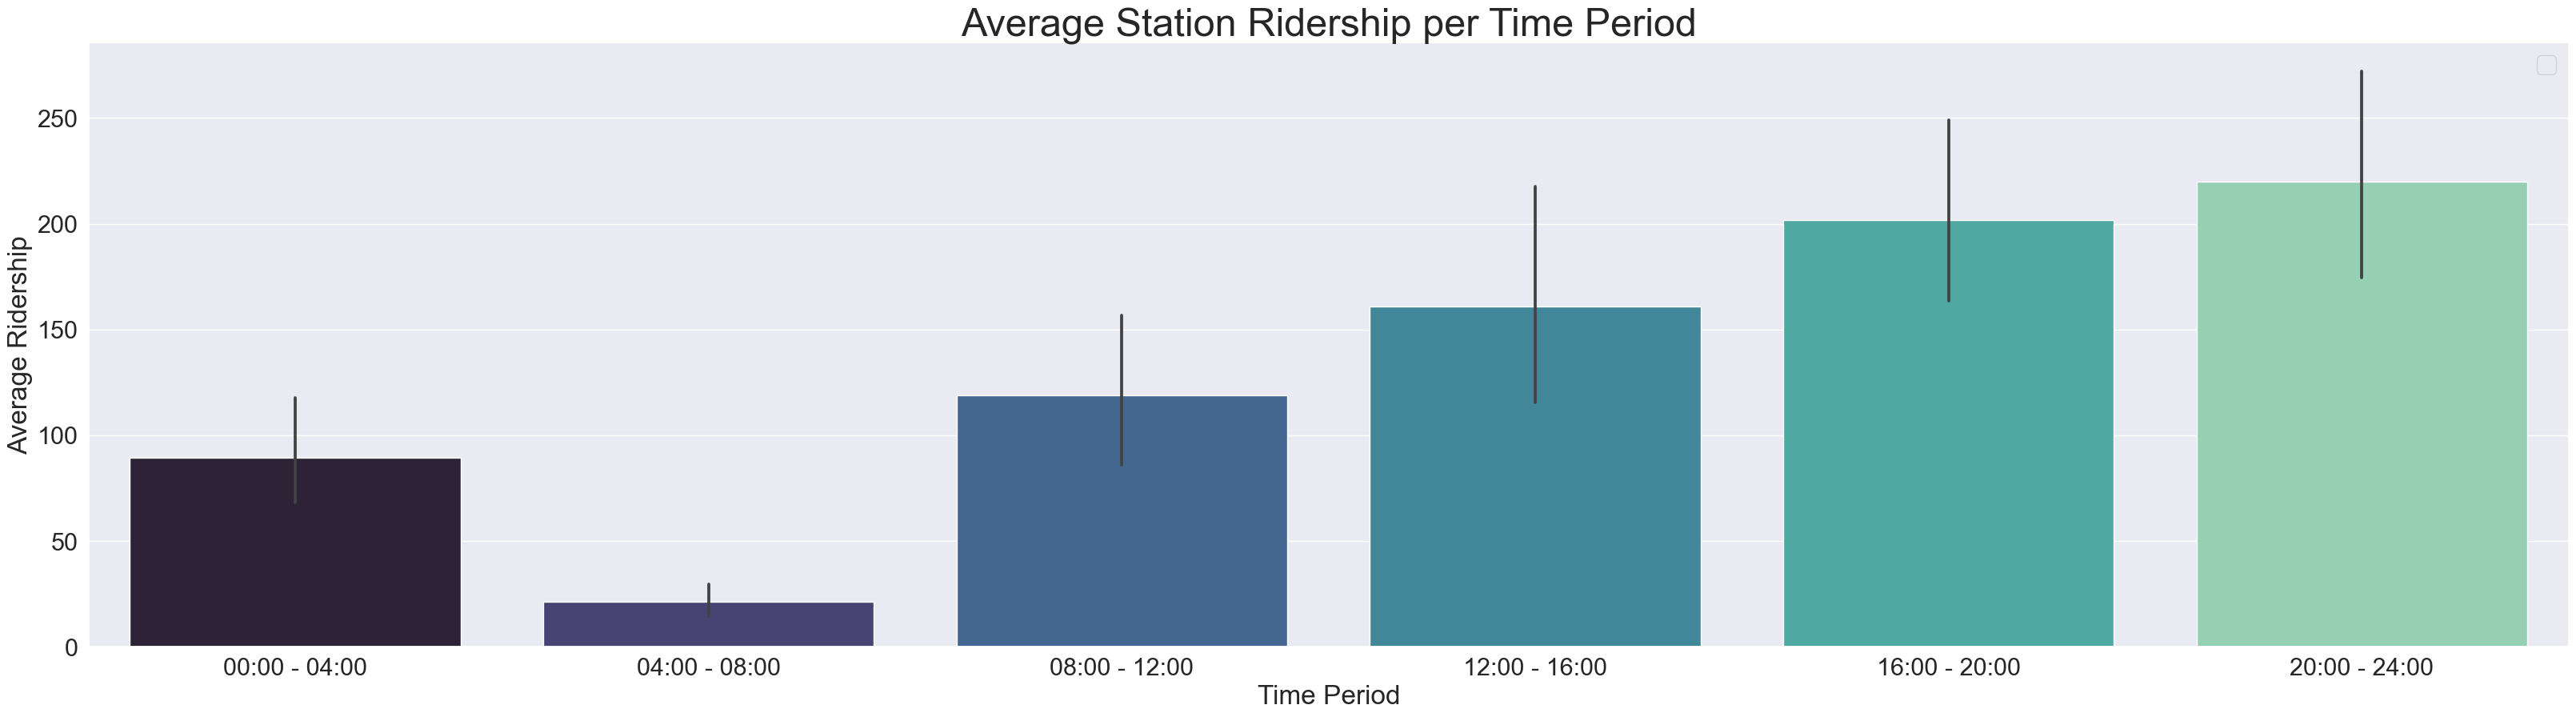

In [60]:
#plot the average ridership per time period
time_periods = sns.barplot(data=grouped_time, x='time_block', y='real_exits_since_audit', palette= 'mako')
plt.legend(loc='upper right')
plt.ylabel('Average Ridership')
plt.xlabel('Time Period')
plt.title('Average Station Ridership per Time Period', fontsize=35)


Text(0.5, 1.0, 'Average Ridership by Station per Time Period')

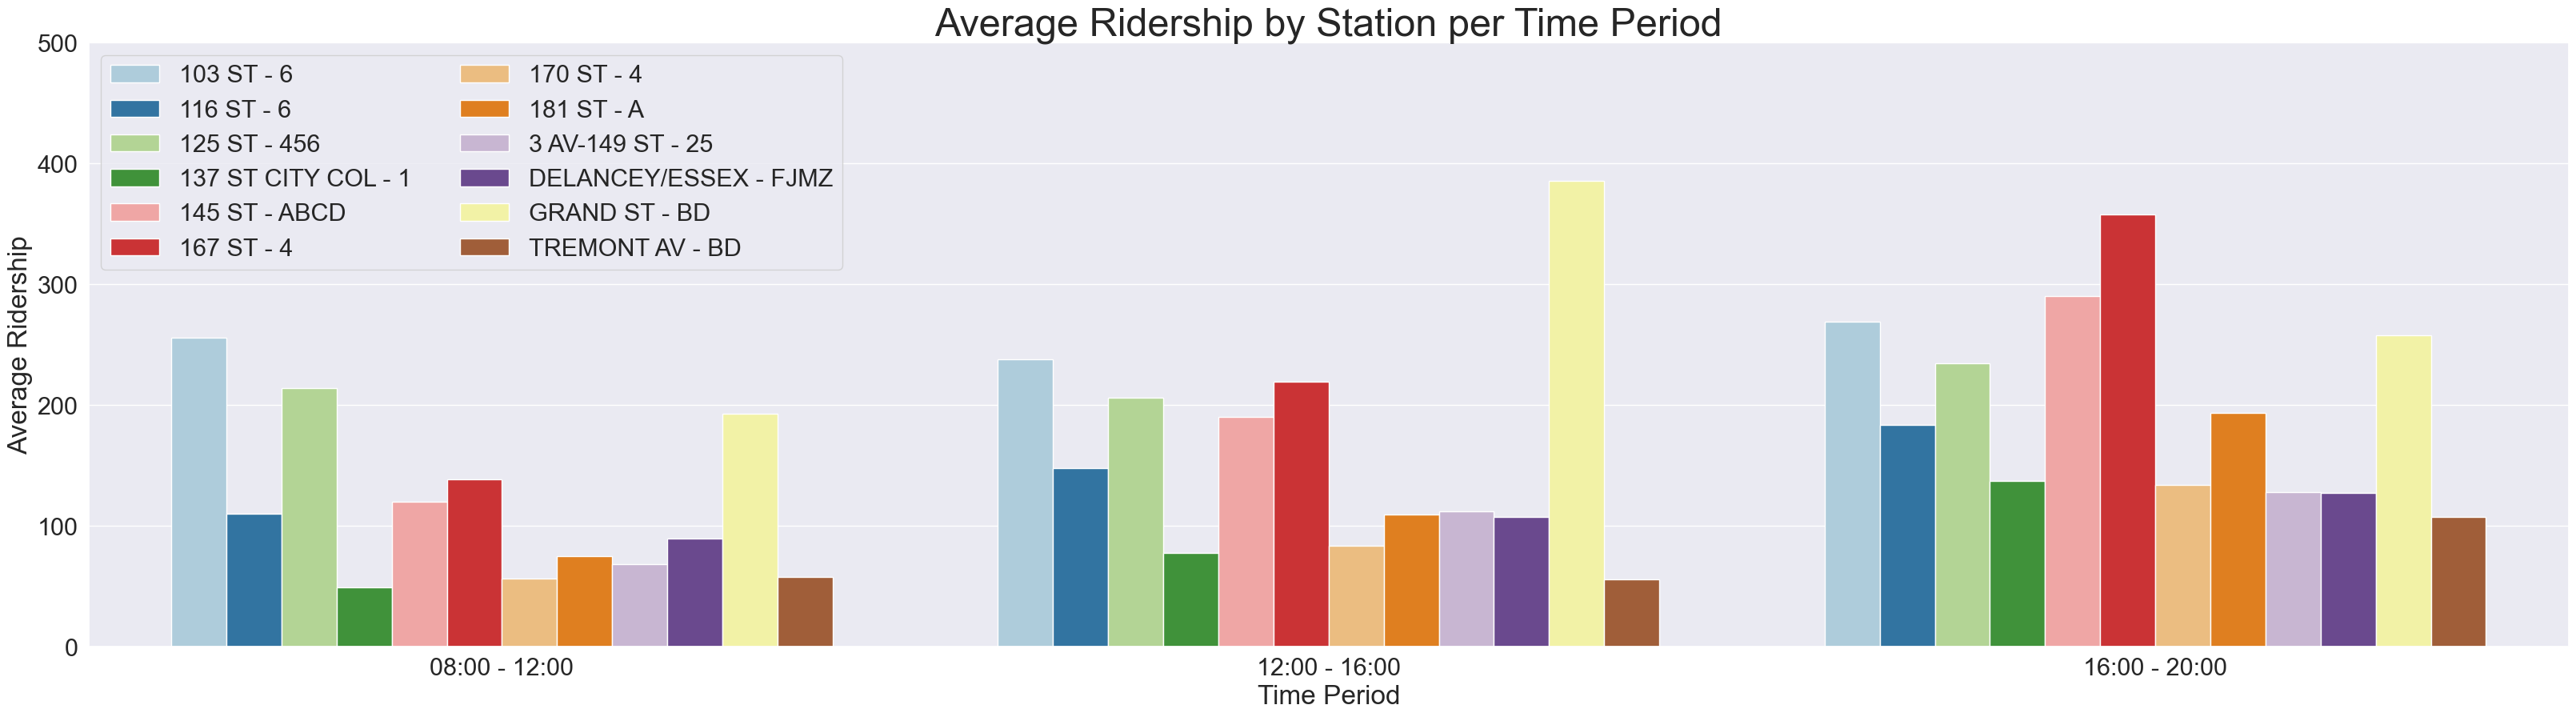

In [61]:
#plot ridership per time period by station
grouped_daytime = grouped_time[(grouped_time.time_block == '08:00 - 12:00') |
                              (grouped_time.time_block == '12:00 - 16:00')|
                              (grouped_time.time_block == '16:00 - 20:00')]
time_periods = sns.barplot(data=grouped_daytime, x='time_block', y='real_exits_since_audit', hue='station', palette = 'Paired')


plt.legend(loc='best', ncol=2)
plt.ylim(top=500)
plt.xlabel('Time Period')
plt.ylabel('Average Ridership')
plt.title('Average Ridership by Station per Time Period', fontsize=35)

Here we can see that even if our team can't be at all 12 stations, all the time, we can prioritize hitting the most popular stations in certain time blocks to increase exposure.

## Mapping station choices and nearby facilities

Lastly, to put our choices in context, we can map the stations we chose along with the clusters of schools and daycares around them, to understand what areas of NYC might be represented in the population we reach.

In [62]:
from shapely.geometry import Point, Polygon
import geopandas as gpd

#get the station locations to plot
station_options = best_options.station.unique()

stations_to_map = station_coords[np.isin(station_coords.station, station_options)]

#flip the coordinates because geopandas reads the coordinates in a different
#order than geopy did
flipped_coord_list = []
for item in stations_to_map.coordinate:
    flipped_coord_list.append(item[::-1])
stations_to_map['flipped_coord'] = flipped_coord_list

stations_to_map['geometry'] = [Point(xy) for xy in stations_to_map.flipped_coord]


#get the nursuries and school locations to plot
school_nursery_mask = close_together.school_daycare[np.isin(close_together.station, station_options)]
schools_nurserys_to_map = schools_daycares[np.isin(schools_daycares.facility_name,school_nursery_mask)]

#flip the coordinates because geopandas reads the coordinates in a different
#order than geopy did
flipped_coord_list_school = []
for item in schools_nurserys_to_map.coordinate:
    flipped_coord_list_school.append(item[::-1])
schools_nurserys_to_map['flipped_coord'] = flipped_coord_list_school

schools_nurserys_to_map['geometry'] = [Point(xy) for xy in schools_nurserys_to_map.flipped_coord]

stations_to_map = gpd.GeoDataFrame(stations_to_map, geometry='geometry')
schools_nurserys_to_map = gpd.GeoDataFrame(schools_nurserys_to_map, geometry='geometry')

schools_nurserys_to_map.head(3)                                  

facility_name   latitude  longitude               coordinate  \
13       Calderon, Benita  40.851936 -73.907683  (40.851936, -73.907683)   
126  Ramkoomar, Lilmattie  40.852241 -73.902124  (40.852241, -73.902124)   
131    Heredia, Francisca  40.718973 -73.992404  (40.718973, -73.992404)   

               flipped_coord                    geometry  
13   (-73.907683, 40.851936)  POINT (-73.90768 40.85194)  
126  (-73.902124, 40.852241)  POINT (-73.90212 40.85224)  
131  (-73.992404, 40.718973)  POINT (-73.99240 40.71897)

In [63]:
#use a downloaded shapefile of NYC as a basemap
nyc_map = gpd.read_file('geo_export_1907e8ca-31f2-4dd6-b11d-793237ac73f8.shp')

nyc_map.geometry = nyc_map.geometry.set_crs(epsg=4326, allow_override=True)
print(nyc_map.crs)
nyc_map.geometry.head(3)

epsg:4326


0    POLYGON ((-73.74251 40.59909, -73.74259 40.599...
1    POLYGON ((-73.92091 40.55837, -73.92092 40.558...
2    POLYGON ((-73.79829 40.59817, -73.79837 40.598...
Name: geometry, dtype: geometry

<AxesSubplot:title={'center':'NYC Subway Stations with High Ridership in Close Proximity to Schools & Daycares'}>

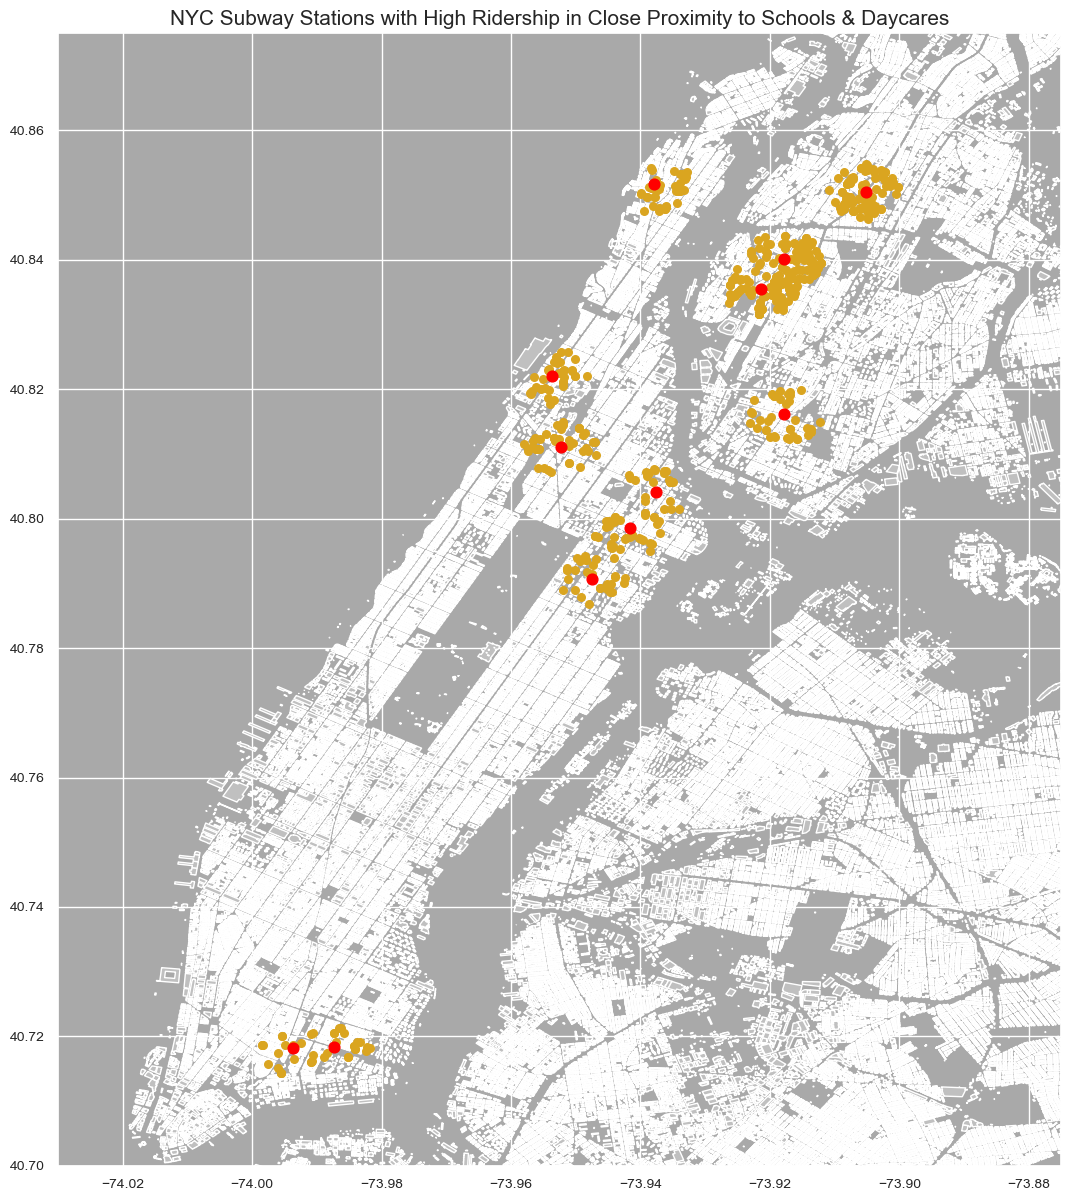

In [69]:
#plot the coordinates on our NYC basemap - stations in red and facilities in yellow 
fig,ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, color='silver')

ax.set_xlim(left=-74.03, right=-73.875)
ax.set_ylim(bottom=40.7, top=40.875)
ax.set_facecolor('darkgrey')
ax.set_title('NYC Subway Stations with High Ridership in Close Proximity to Schools & Daycares', fontsize=15)
plt.setp(ax.get_xticklabels(), Fontsize=10)
plt.setp(ax.get_yticklabels(), Fontsize=10)

schools_nurserys_to_map.plot(ax=ax, markersize=30, color="goldenrod", marker="o", label="School or Daycare")
stations_to_map.plot(ax=ax, markersize=60, color="red", marker="o", label="Subway Station")


## Concluding Recommendations

With our newfound insights on location, proximity to schools, and ridership by time of day, we can create a schedule for the WTWY team that uses their time most efficiently. During school pickup and dropoff times, the team should prioritize those stations that are surrounded by school facilities, whereas during the schoolday they can focus on high-ridership stations. Teams should be placed on street entrances to the subway, ensuring exposure to pedestrians in the area. 

|    Time Block    |    Priority Stations   |
| -----------------| -----------------------|
| 8-9am **School Drop-off** | 167 St, 170 St, Tremont, 145 St|
| 9am-12pm | 103 St, 125 St, Grand St|
|12pm-3pm | 103 St, 167 St, Grand St|
| 3pm-5pm **School Pick-Up** | 167 St, 170 St, Tremont, 145 St|
| 5pm-8pm | 167 St, 145 St, Grand St, 103 St|

Moving forward, future work on this project could include:
* Optimizing the schedule for the WTWY team schedule, bandwidth, and travel locations
* Analyzing two weeks of data at the stations and reevaluate based on successes and failures
* Incorporating demographic data to more closely target certain subsets of New Yorkers